# 0.0 Imports

In [1]:
import pandas     as pd
import numpy      as np
import random

import matplotlib.pyplot as plt
import seaborn    as sns 

from IPython.core.display   import HTML

from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing  import RobustScaler, MinMaxScaler
import pickle

from boruta import BorutaPy

from imblearn                import combine as c

from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en

from sklearn                 import dummy
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor

import xgboost               as xgb

from sklearn.metrics         import f1_score
from sklearn.model_selection import cross_val_score

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, y_training, xvalidation, yvalidation, kfold, model_name, model, verbose): 
    
    # x_traning = x_train_allcols
    # xvalidation = x_val
    # yvalidation = y_val

    hyperparam_list = []
    final_result = pd.DataFrame()

    f1_score_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n Kfold number: {}'.format(k))
        
        # datasets
        xtraining = x_training#.drop(['id_cliente', 'limite_adicional'])
        ytraining = y_training
        #xvalidation = x_val
        xvalidation = x_val.drop(['investe_exterior', 'num_emprestimos', 'pessoa_polit_exp', 'id_cliente', 'limite_adicional'], axis=1) 
        yvalidation = y_val

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = f1_score(yvalidation, yhat)

        # storage
        f1_score_list.append(m_result)

    print(f1_score_list)
    print(pd.DataFrame( { 'Model Name': model_name,
                                'F1 Score Mean': np.round(np.mean(f1_score_list),2)
                             }, index=[0] ))
    cv_mean = np.round(np.mean(f1_score_list),2)
    return cv_mean



def personal_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:90% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:,.2f}'.format)

    # seaborn settings
    sns.set(rc={'figure.figsize':(15,6)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)

personal_settings()

## 0.2 Loading Data

In [3]:
train = pd.read_csv(r"C:\Users\ferki\repos\credit_card\data\train.csv", low_memory=False)
test = pd.read_csv(r"C:\Users\ferki\repos\credit_card\data\test.csv", low_memory=False)

In [4]:
train.sample()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
5101,8700,42,564.90,"2,529.47","82,476.77",234.76,32.26,100,9,7,32,24,11,27,Não,Não,Negar


# 1.0 Data Description

In [5]:
df2 = train.copy()

## 1.1 Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Cols: {}'.format( df2.shape[1] ) )

Number of Rows: 9500
Number of Cols: 17


## 1.2 Data types

In [7]:
df2.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.3 Check NA

In [8]:
df2.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.4 Change Data Types

In [9]:
df2.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,"2,577.05","24,196.90",104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,"2,465.39","19,227.38",69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,"1,055.29","42,822.28",134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,"51,786.83",297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,"44,626.85",134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


In [10]:
df2['limite_adicional'].unique()

array(['Negar', 'Conceder'], dtype=object)

In [11]:
df2['investe_exterior'] = df2['investe_exterior'].apply(lambda x: 0 if x=='Não' else 1 )
df2['pessoa_polit_exp'] = df2['pessoa_polit_exp'].apply(lambda x: 0 if x=='Não' else 1 )
df2['limite_adicional'] = df2['limite_adicional'].apply(lambda x: 0 if x=='Negar' else 1 )

## 1.5 Descriptive Statistical

In [12]:
num_attributes = df2.select_dtypes( include=['int', 'float'] )
cat_attributes = df2.select_dtypes( exclude=['int', 'float'] )

### 1.5.1 Numerical attibutes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenete
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id_cliente,1.00,"12,500.00","12,499.00","6,210.53","6,172.50","3,603.05",0.01,-1.20
1,idade,18.00,"8,598.00","8,580.00",126.40,38.00,685.00,9.09,87.61
2,saldo_atual,0.09,"1,602.04","1,601.95",404.53,337.17,217.69,1.62,3.10
3,divida_atual,0.23,"4,998.07","4,997.84","1,437.09","1,175.73","1,156.20",1.19,0.85
4,renda_anual,"10,473.87","23,279,657.98","23,269,184.11","195,037.27","45,991.11","1,454,197.19",11.87,149.39
5,valor_em_investimentos,0.00,"10,000.00","10,000.00",612.00,134.20,"2,002.34",4.44,17.87
6,taxa_utilizacao_credito,20.99,49.56,28.57,32.27,32.26,5.11,0.04,-0.92
7,num_emprestimos,0.00,"1,496.00","1,496.00",10.86,3.00,62.55,16.37,310.98
8,num_contas_bancarias,0.00,"1,779.00","1,779.00",17.55,6.00,120.97,10.88,123.22
9,num_cartoes_credito,1.00,"1,479.00","1,478.00",21.43,6.00,122.67,8.56,76.79


# 2.0 Feature Engineering

In [14]:
df3 = df2.copy()
df3.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,"2,577.05","24,196.90",104.31,31.04,6,5,7,21,14,9,15,0,0,0
1,11920,40,268.87,"2,465.39","19,227.38",69.86,36.92,5,8,5,40,23,10,18,0,0,0
2,8910,36,446.64,"1,055.29","42,822.28",134.20,34.56,0,3,6,26,13,3,15,1,0,0
3,4964,58,321.14,703.05,"51,786.83",297.35,31.49,0,3,7,12,7,2,1,1,0,0
4,10100,35,428.72,891.29,"44,626.85",134.20,28.03,2,8,7,24,10,8,20,1,0,0


## 2.1 Variable Filtering

- 'valor_em_investimentos', 'idade', 'taxa_juros', 'num_emprestimos', 'num_contas_bancarias', 'num_cartoes_credito', 'num_pgtos_atrasados', 'num_consultas_credito'

In [15]:
df4 = df3.copy()

In [16]:
df4.shape[0]

9500

In [17]:
# Idade
print(df4[df4['idade']>100].shape[0])
print('idade', round(df4[df4['idade']>100].shape[0]*100.00 / df4.shape[0],2), '%')
df4 = df4[df4['idade']<=100]

280
idade 2.95 %


In [19]:
# renda anual
df4_v4 = df4_v4[df4_v4['renda_anual']<=1000000]

In [20]:
df4_v4 = df4_v4[df4_v4['num_emprestimos']<=100]

In [21]:
df4_v4 = df4_v4[df4_v4['num_contas_bancarias']<=100]

In [22]:
df4_v4 = df4_v4[df4_v4['num_cartoes_credito']<=100]

In [23]:
df4_v4 = df4_v4[df4_v4['num_pgtos_atrasados']<=100]

In [24]:
df4_v4 = df4_v4[df4_v4['num_consultas_credito']<=100]

In [25]:
df4_v4 = df4_v4[df4_v4['taxa_juros']<=100]

In [26]:
# Avaliar no ciclo 05 pós fine tuning (ciclo 04) eliminar todas essas linhas
166+143+64+187+114+42+103+280-9500

-8401

In [27]:
df4_v4.shape[0]

8438

# 3.0 EDA

In [28]:
df5 = df4.copy()

## 3.1 Univariate Analysis

In [29]:
num_df5 = df5.select_dtypes(include=['int64','float64'])
cat_df5 = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 3.1.1 Response Variable

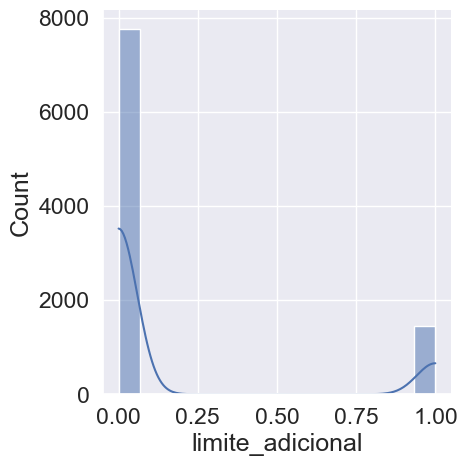

In [30]:
sns.displot(df5['limite_adicional'], kde=True)

### 3.1.2 Numerical Variables

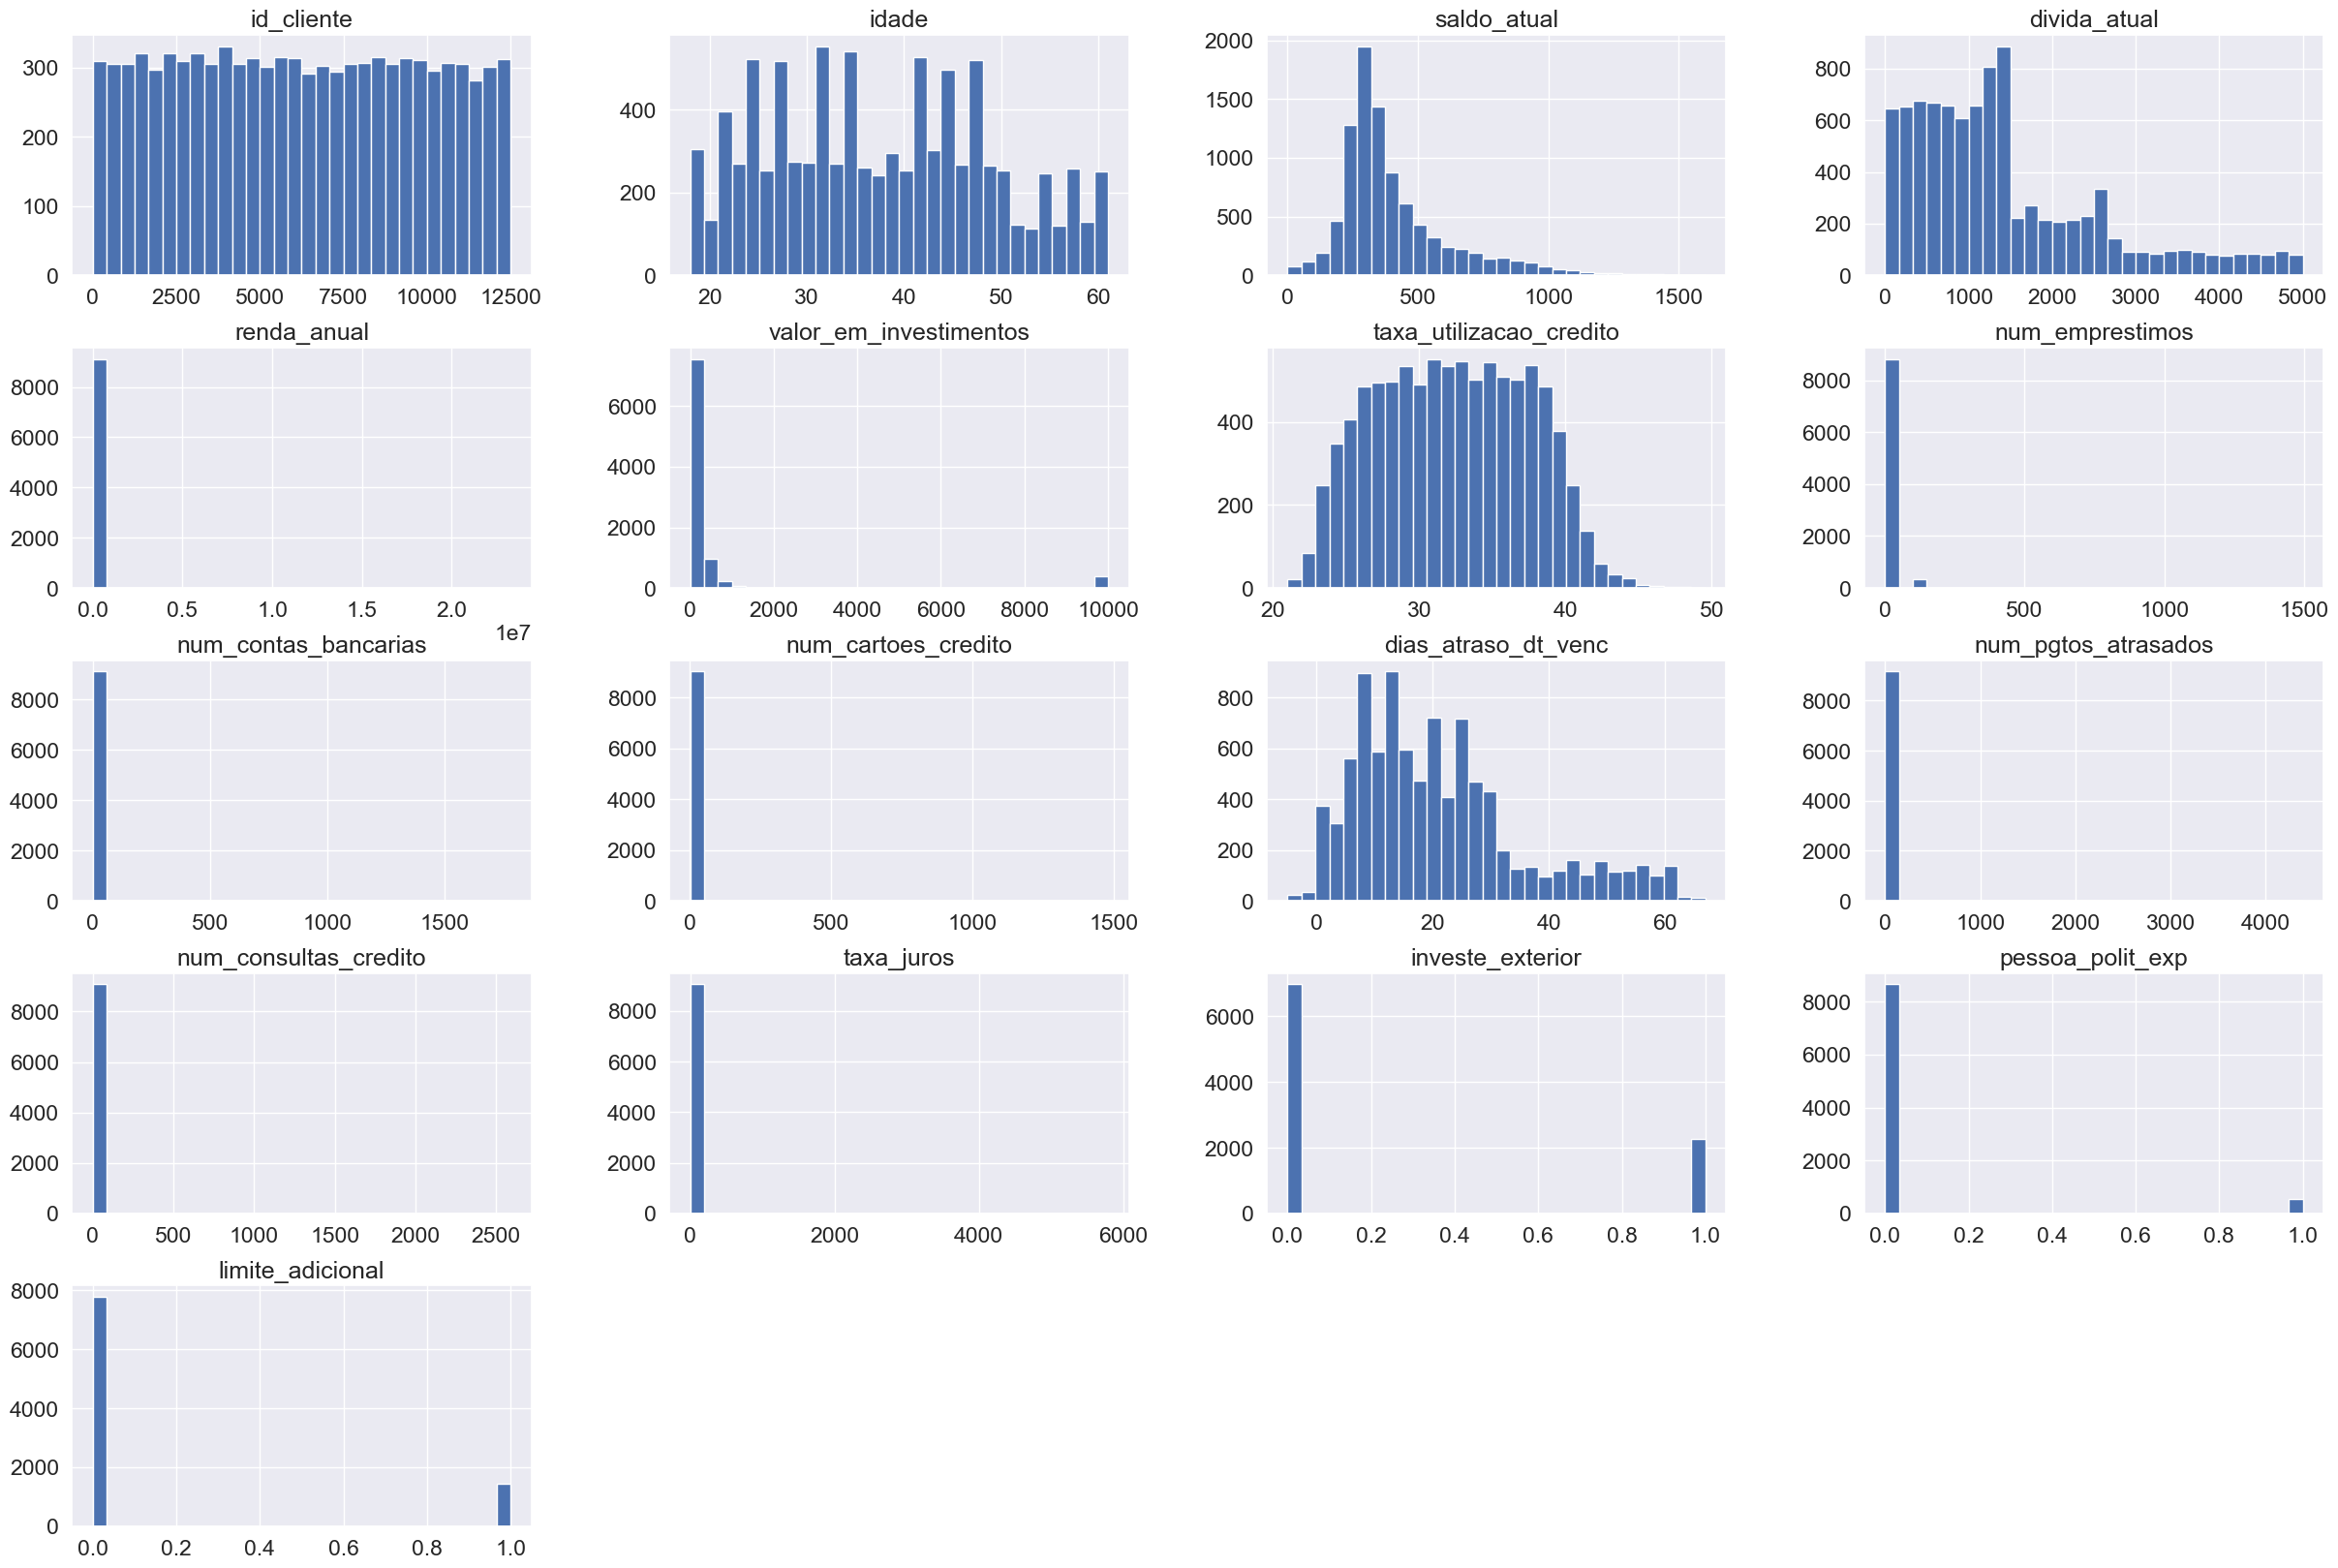

In [31]:
plt.rcParams['figure.figsize'] = [30, 20]
num_df5.hist(bins=30);


## 3.2 Bivariate Analysis

### H1 - Clientes com maior idade tem menor pagamentos em atraso
 - Hipótese é falsa, pois os clientes mais velhos apresentam alto número de pagamentos em atraso.

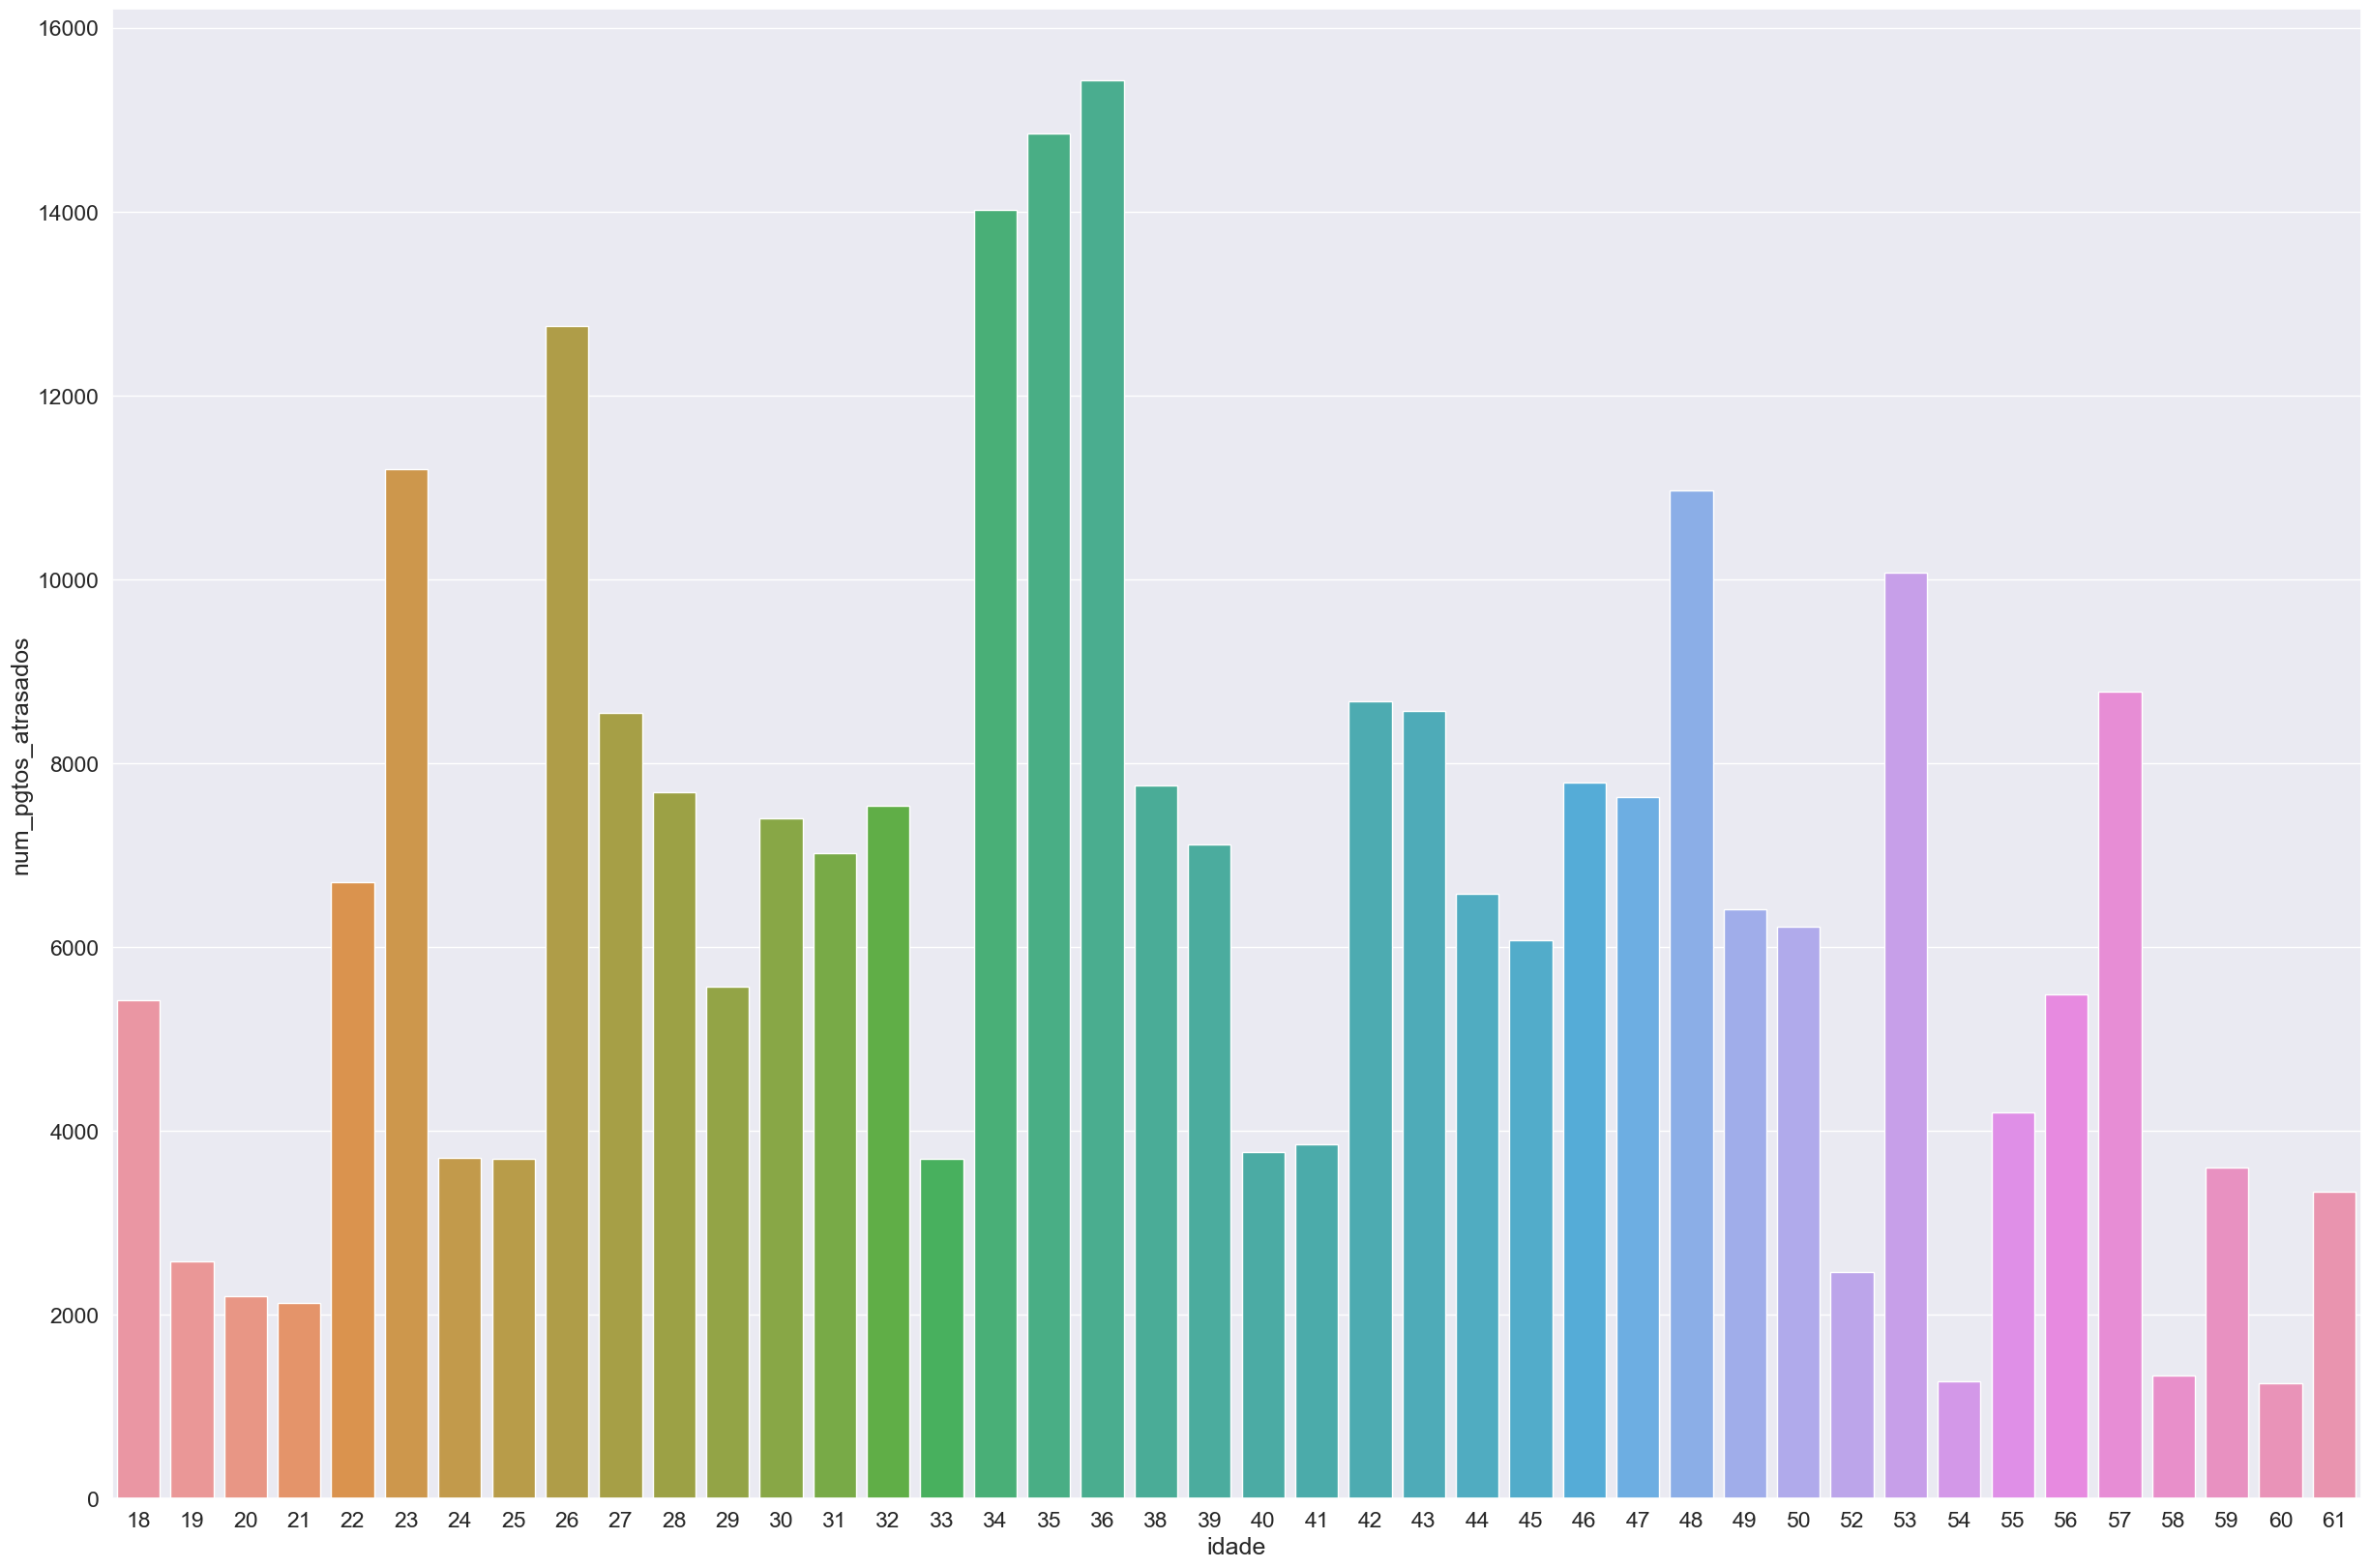

In [32]:
aux1 = df5[['idade', 'num_pgtos_atrasados']].groupby( 'idade' ).sum().reset_index()
sns.barplot( x='idade', y='num_pgtos_atrasados', data=aux1 );

### H2 - Clientes mais novos recebem mais negativas de limite adicional
   - Hipótese falsa, pois clientes mais velhos também recebem negativas de limite adicional

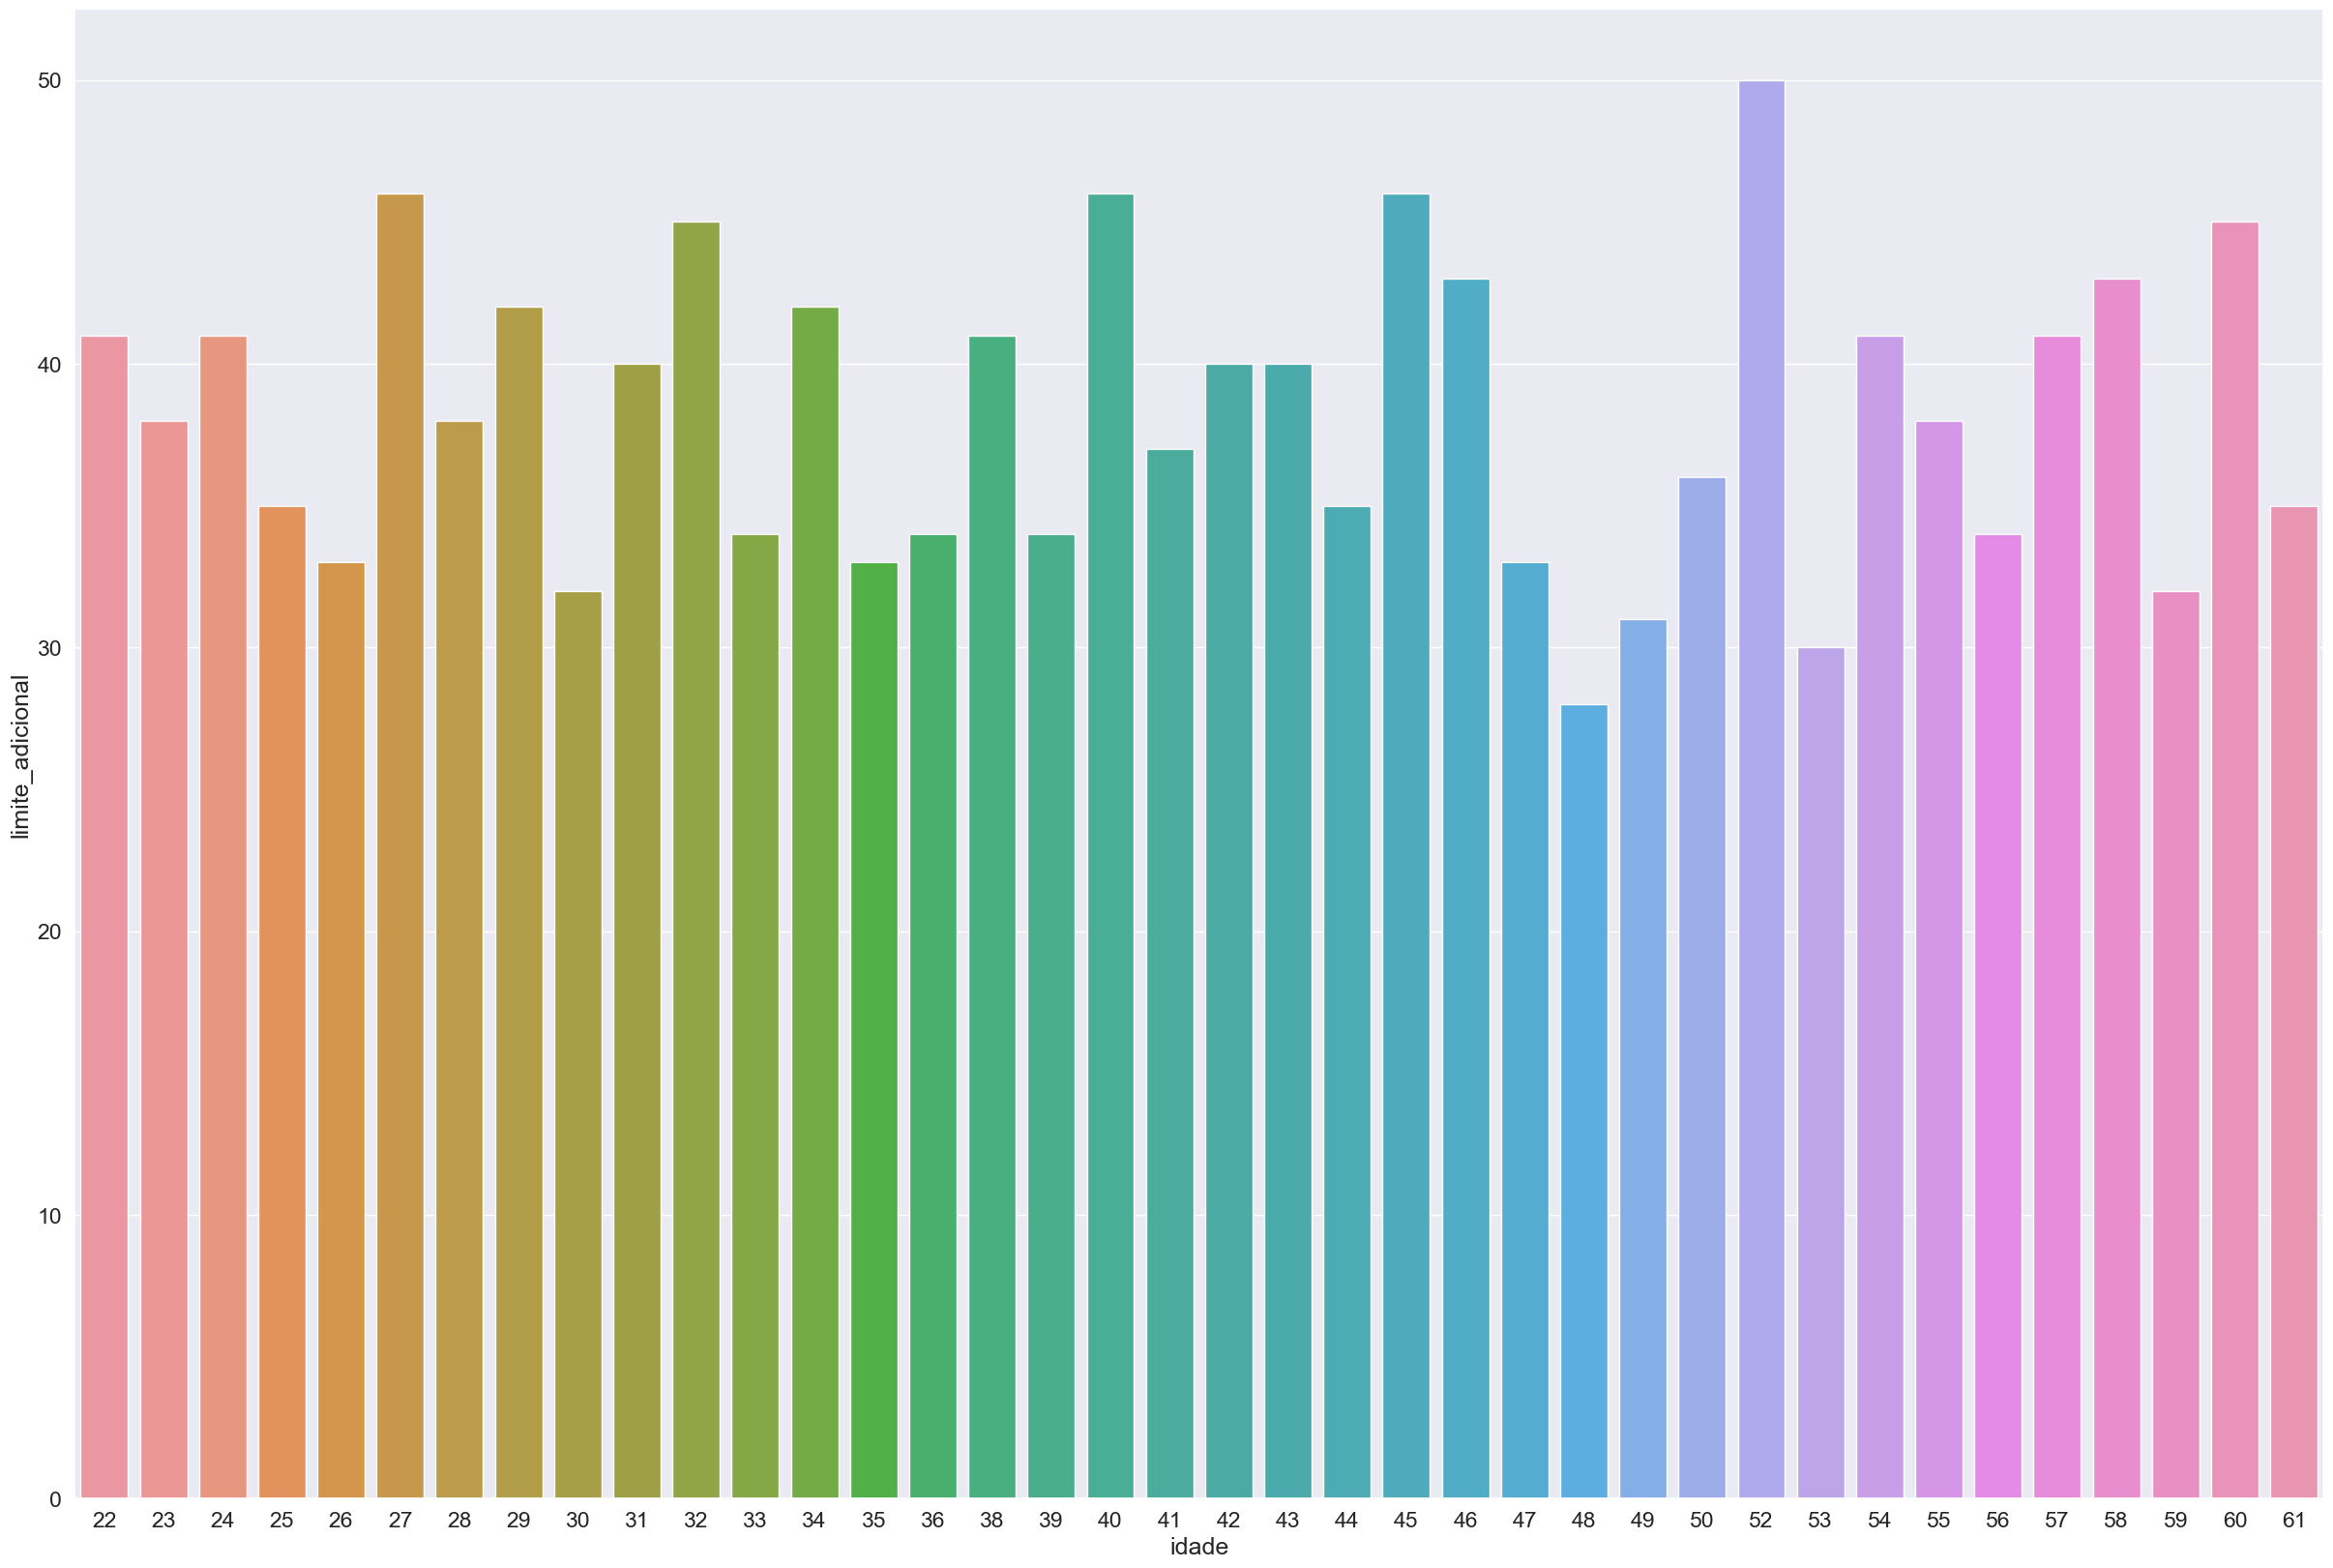

In [33]:
aux1 = df4[df4['limite_adicional']==0].groupby('idade').count().reset_index()
aux1 = df4[df4['limite_adicional']==1].groupby('idade').count().reset_index()
sns.barplot( x='idade', y='limite_adicional', data=aux1);

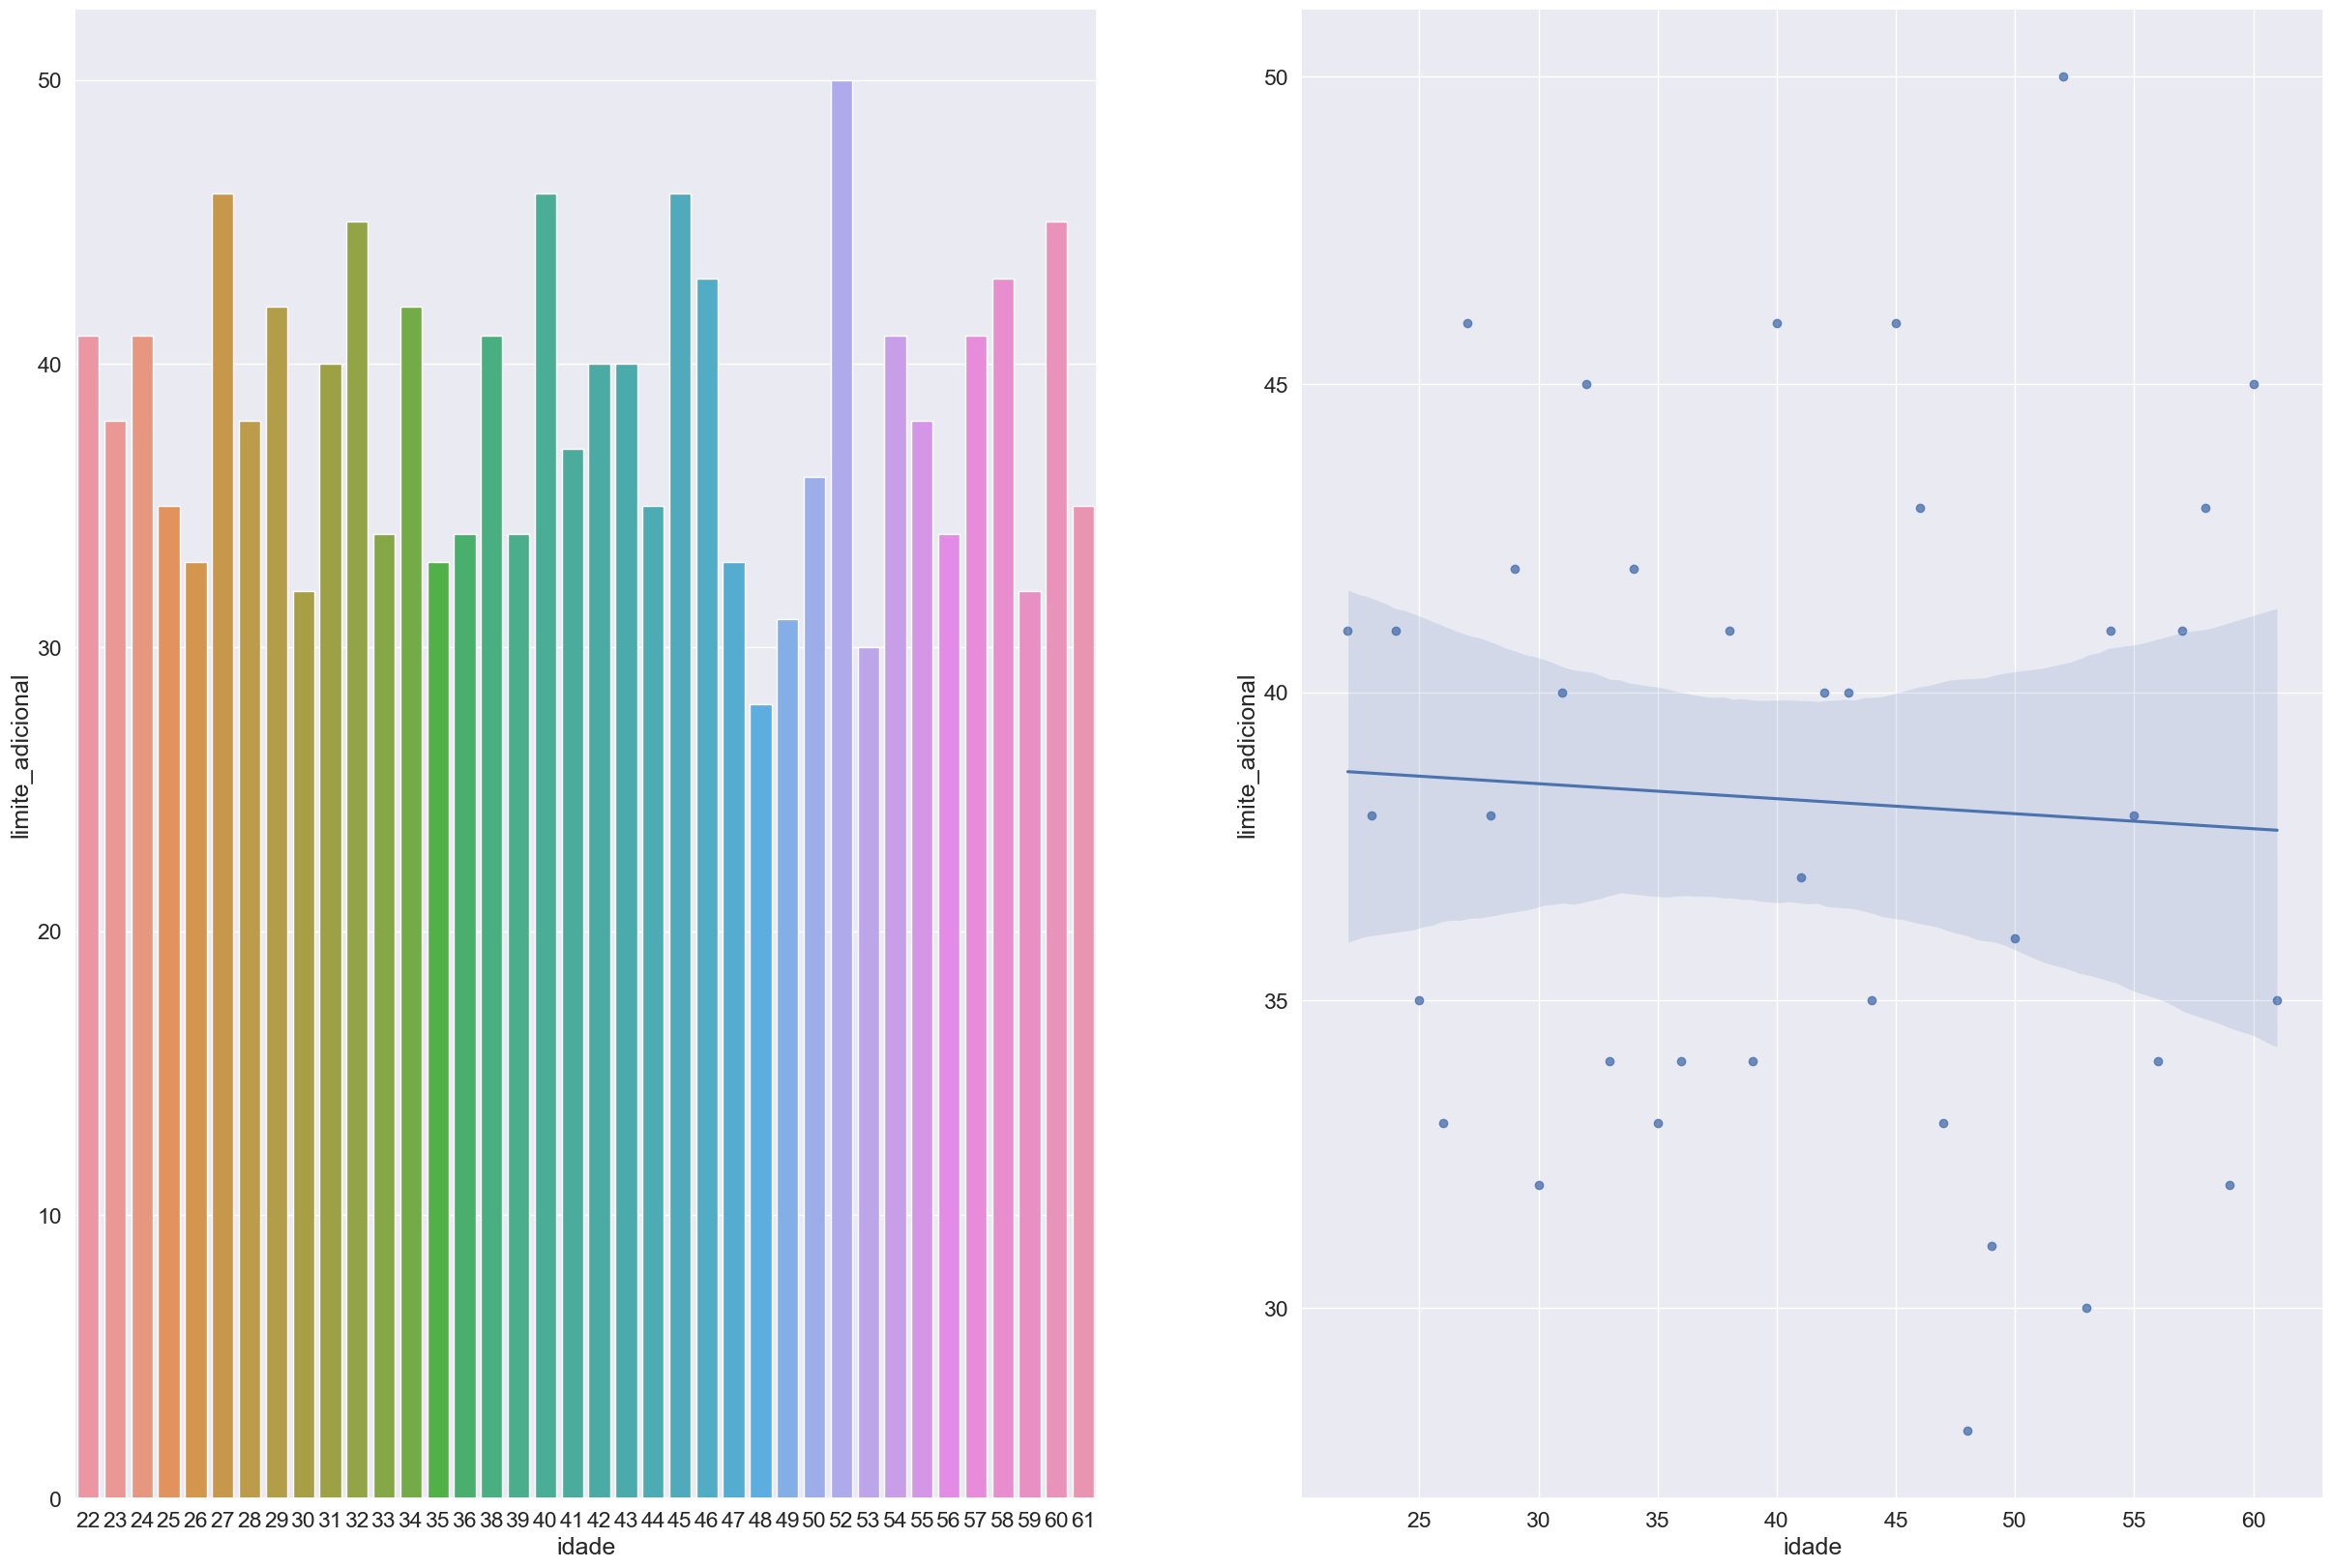

In [34]:
aux1 = df4[df4['limite_adicional']==0].groupby('idade').count().reset_index()
aux1 = df4[df4['limite_adicional']==1].groupby('idade').count().reset_index()
#sns.barplot( x='idade', y='limite_adicional', data=aux1);

#aux = df4[['idade', 'limite_adicional']].groupby( 'idade' ).sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='idade', y='limite_adicional', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.regplot( x='idade', y='limite_adicional', data=aux1 );

#plt.subplot( 1, 3, 3 )
#sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3 - Clientes com maior investimento possuem menor dias de atraso 
 - Hipótese falsa porque mesmo com maior investimento, clientes apresentam maior dias de atraso

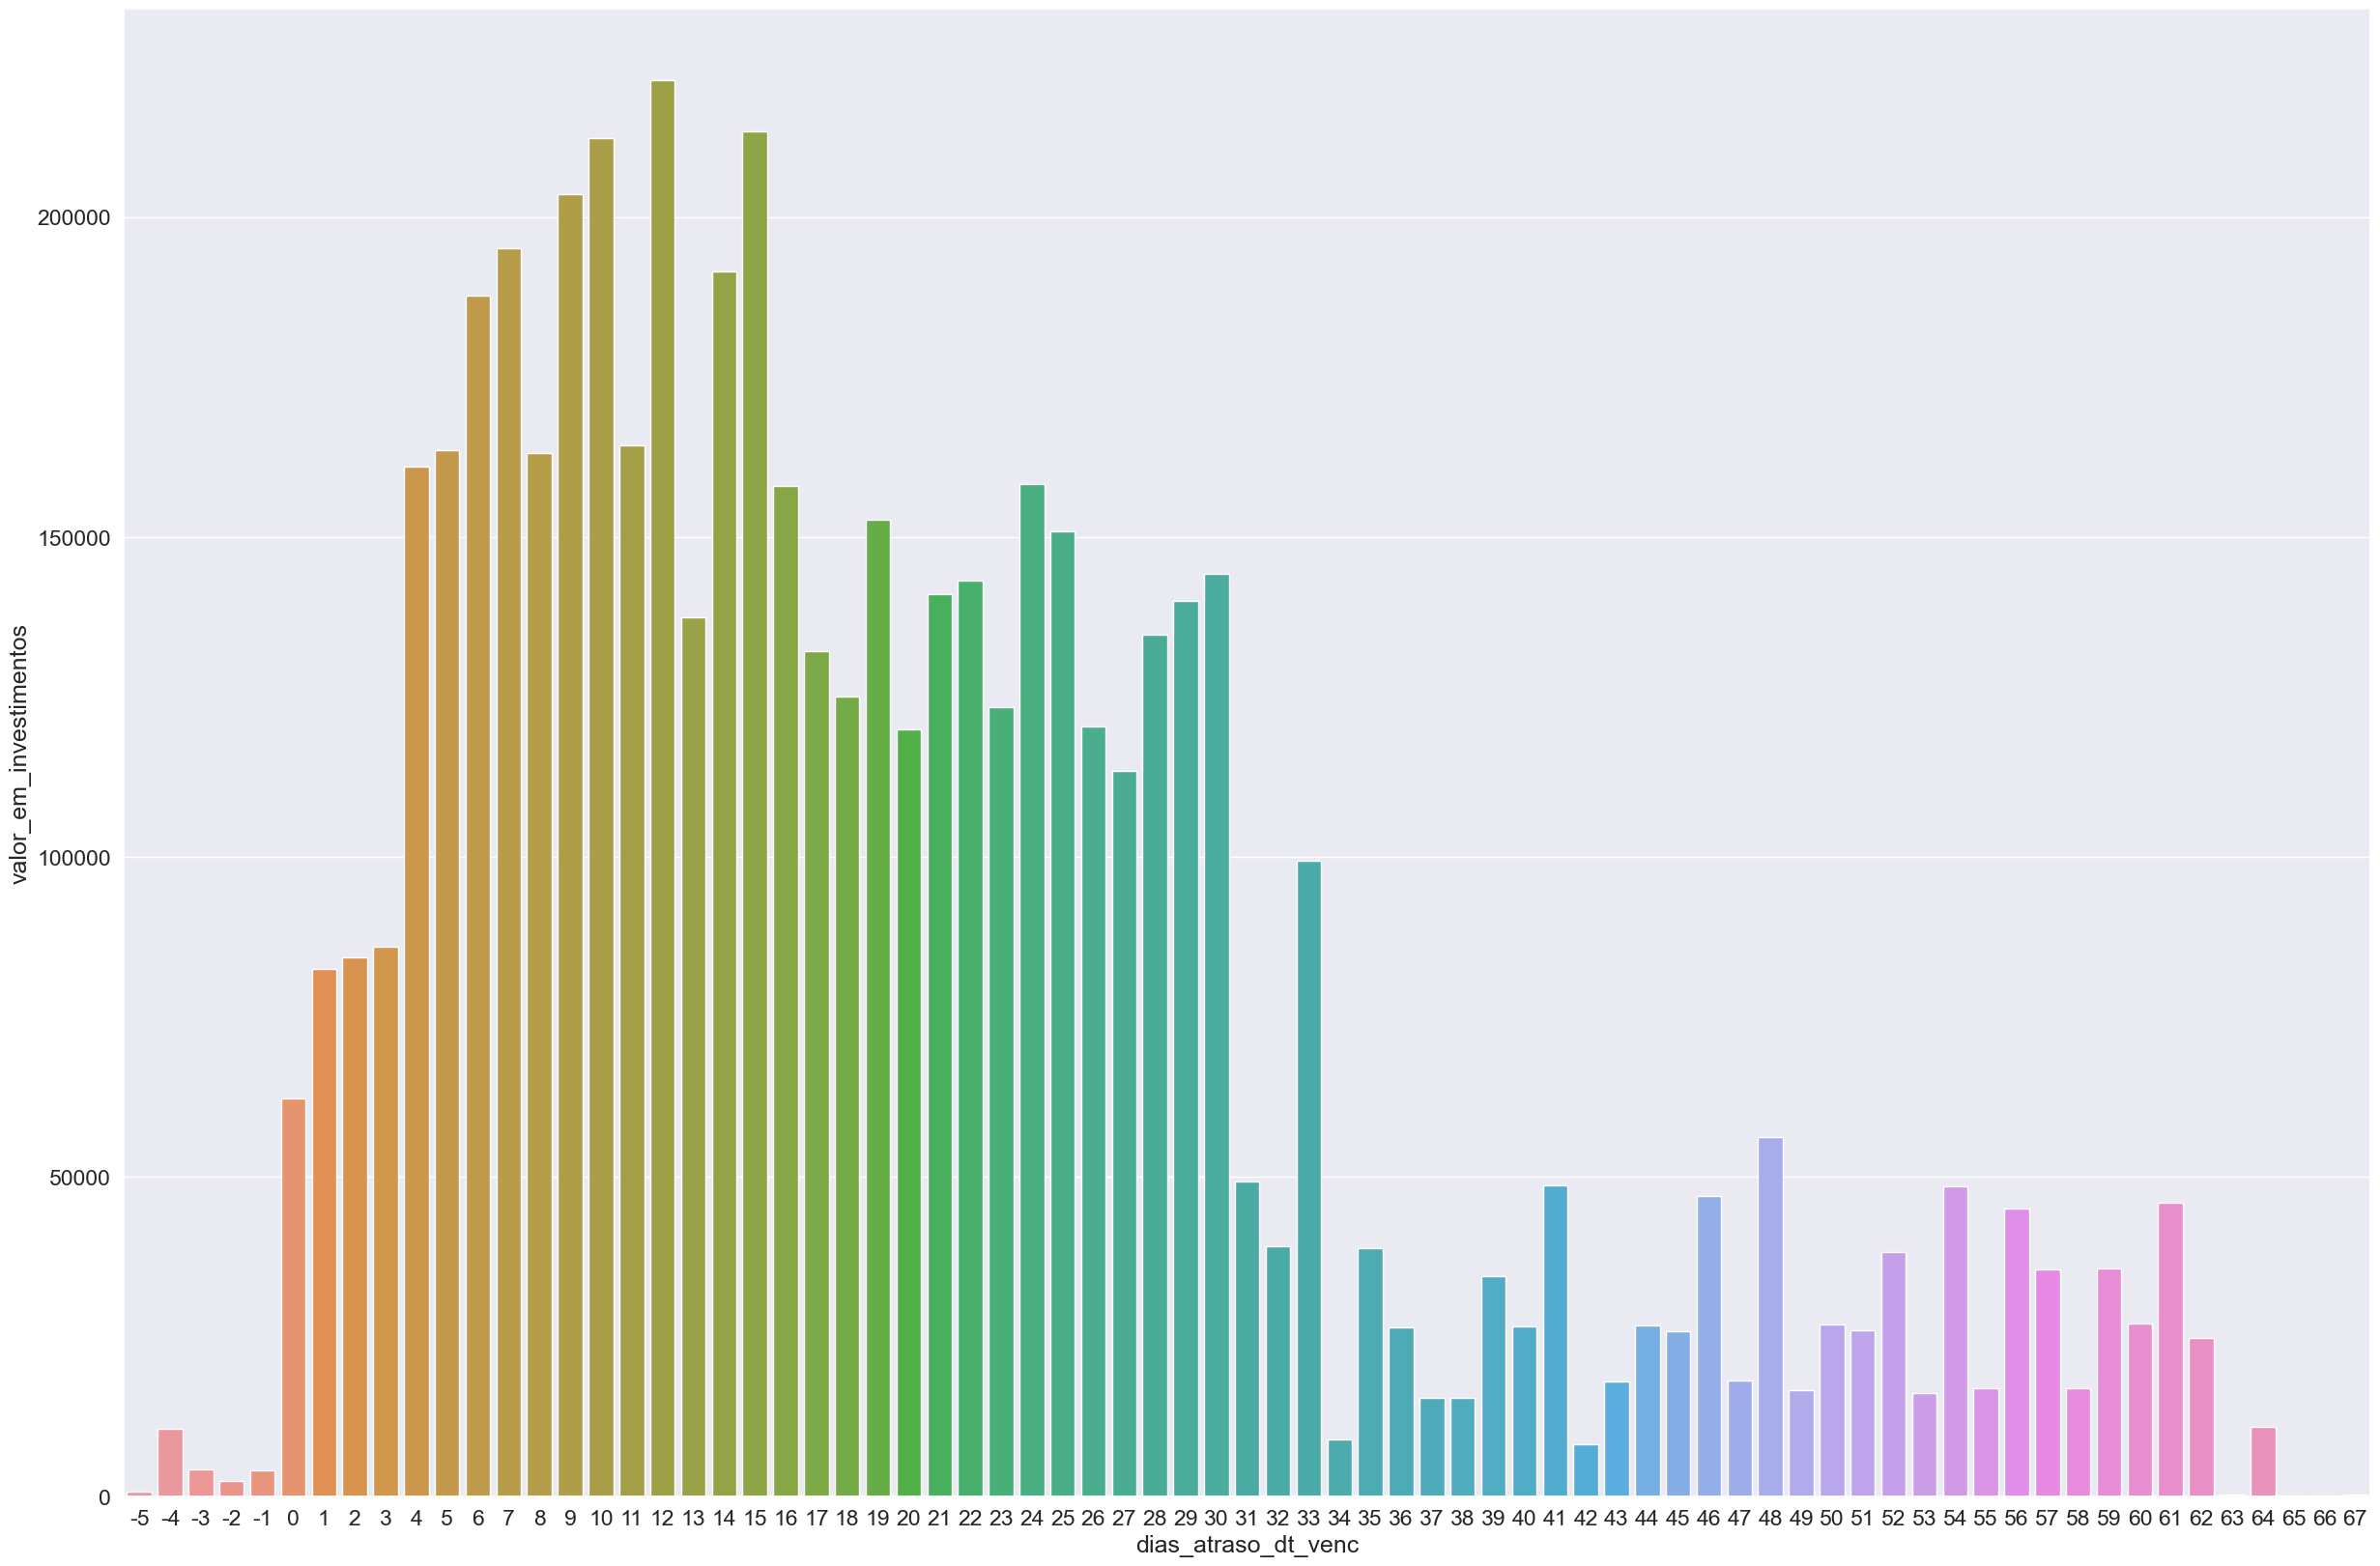

In [35]:
aux1 = df4[['dias_atraso_dt_venc', 'valor_em_investimentos']].groupby( 'dias_atraso_dt_venc' ).sum().reset_index()
sns.barplot( x='dias_atraso_dt_venc', y='valor_em_investimentos', data=aux1 );

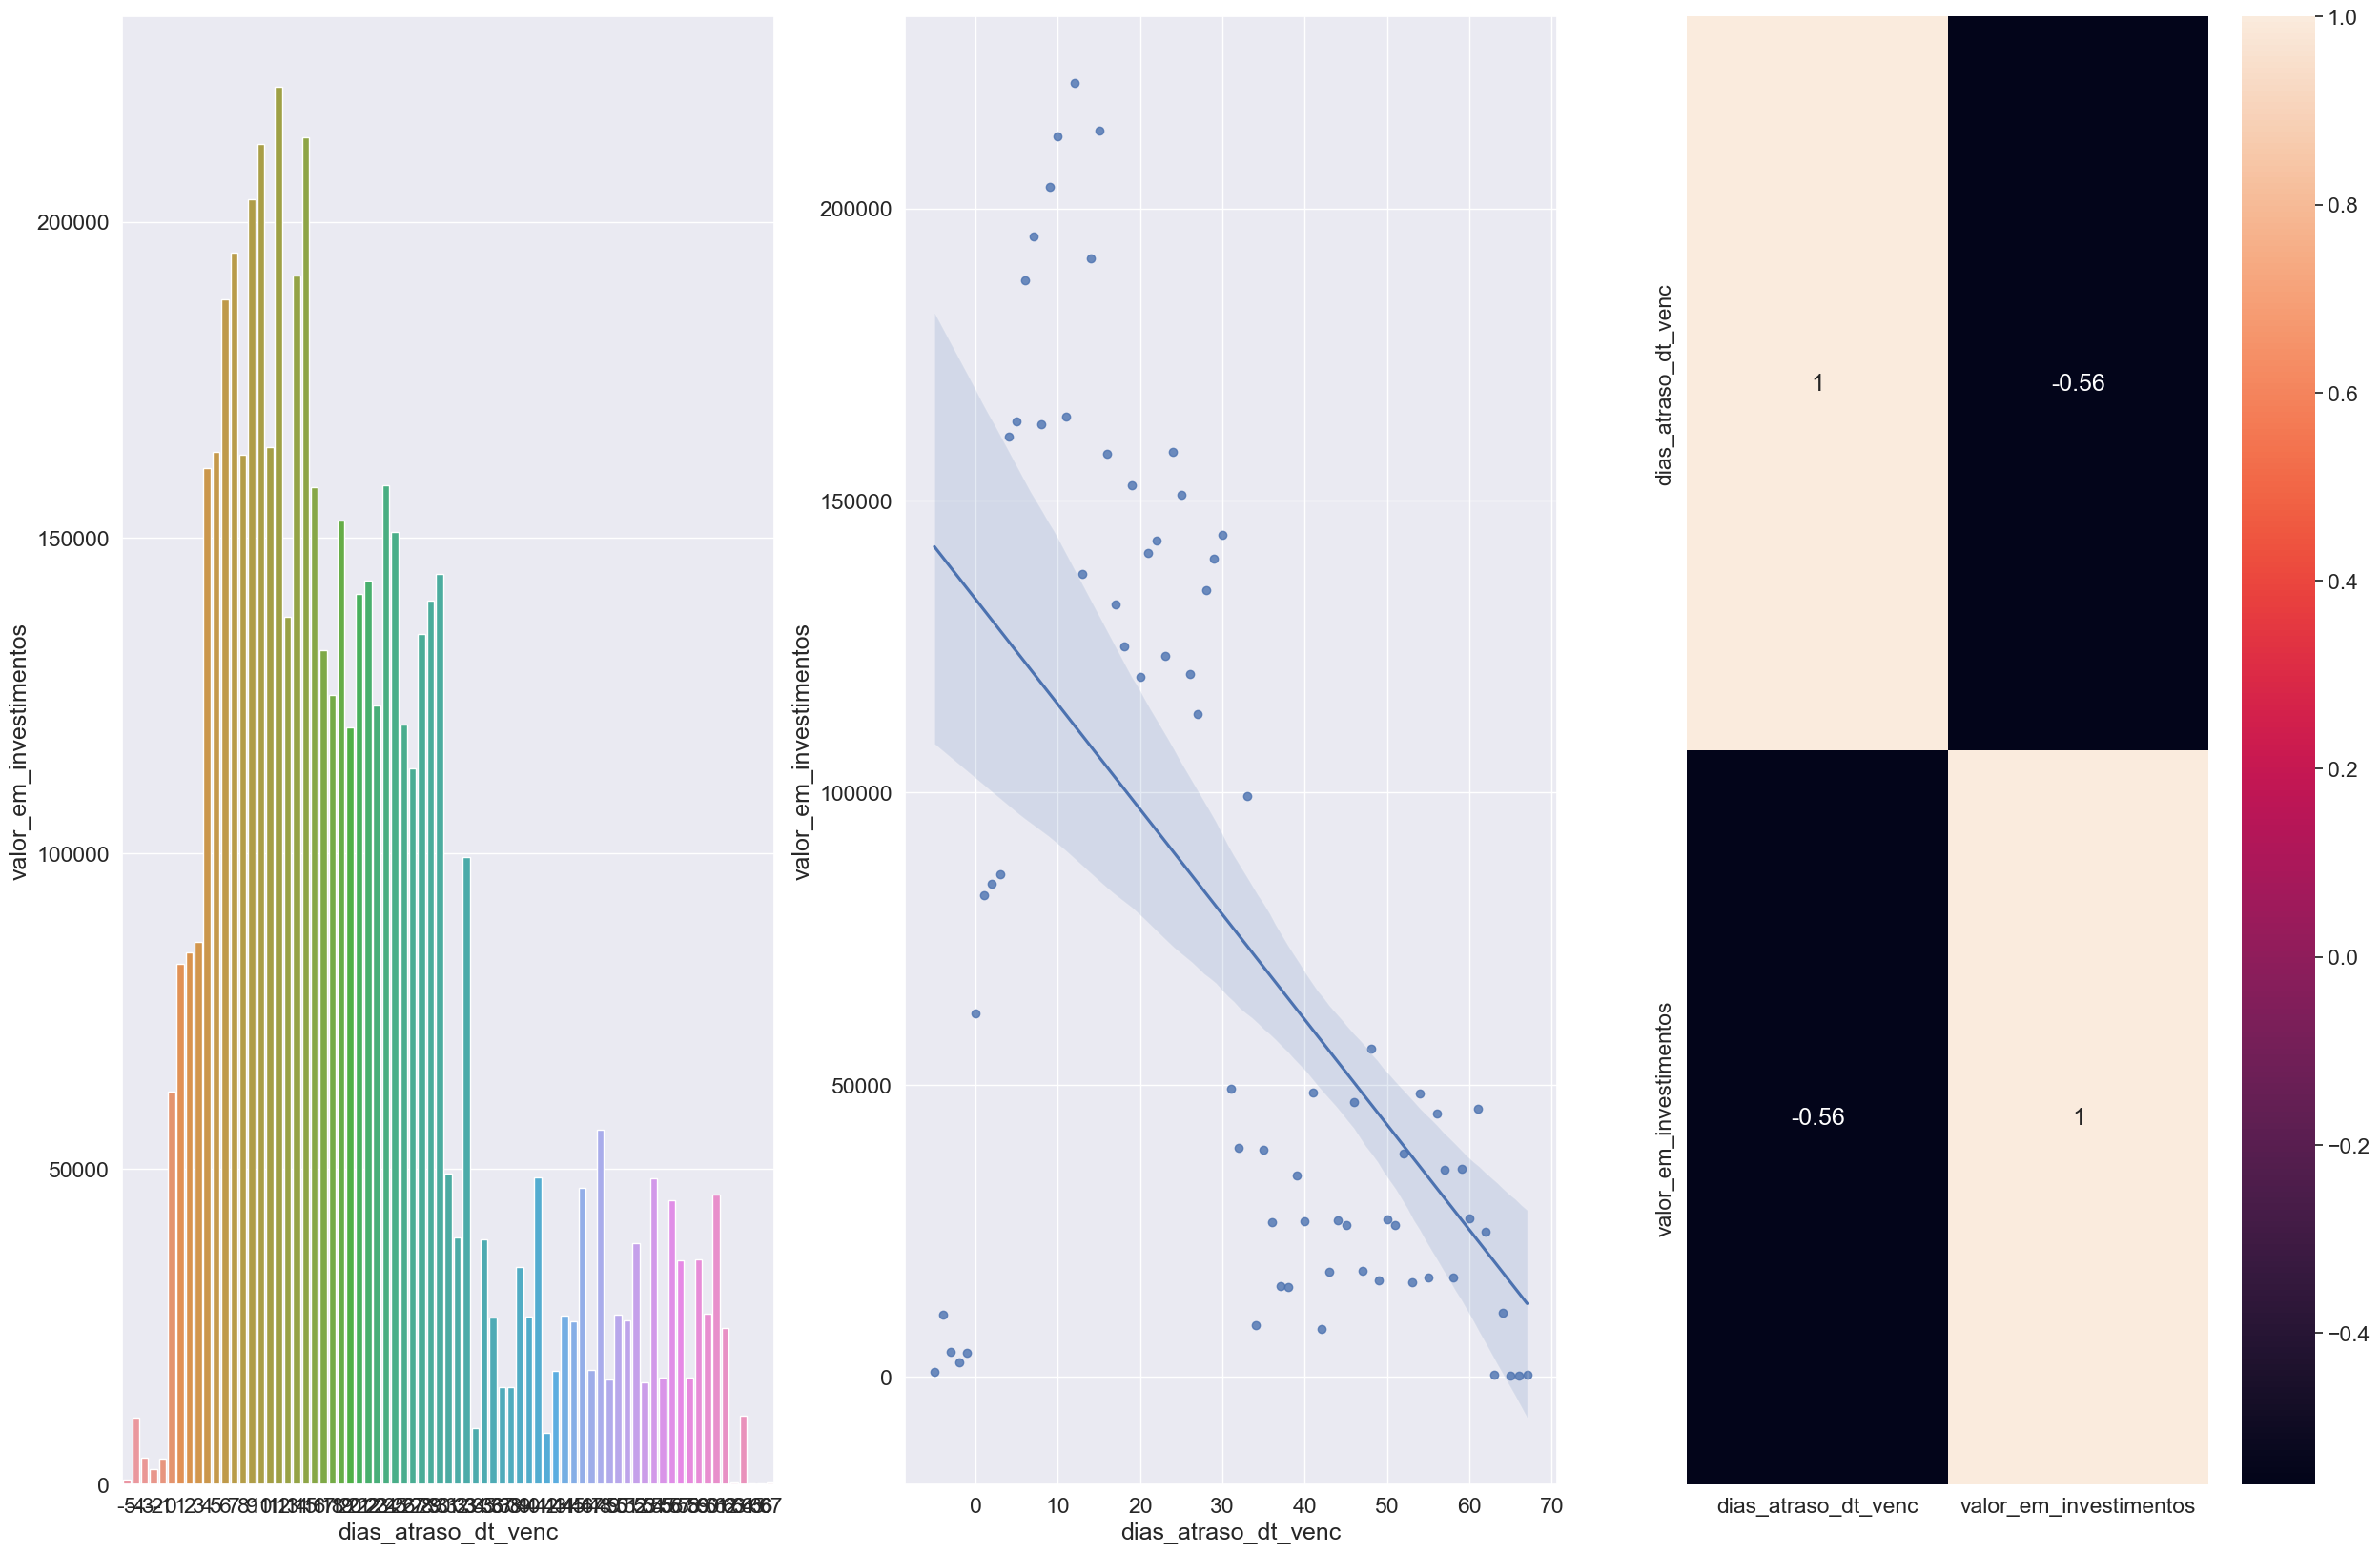

In [36]:
aux1 = df4[['dias_atraso_dt_venc', 'valor_em_investimentos']].groupby( 'dias_atraso_dt_venc' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='dias_atraso_dt_venc', y='valor_em_investimentos', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='dias_atraso_dt_venc', y='valor_em_investimentos', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H4 - Clientes com menor número de empréstimos possuem maior renda anual       
   - Hipótese verdadeira, pois clientes com maior renda anual, apresentam menor número de empréstimos.

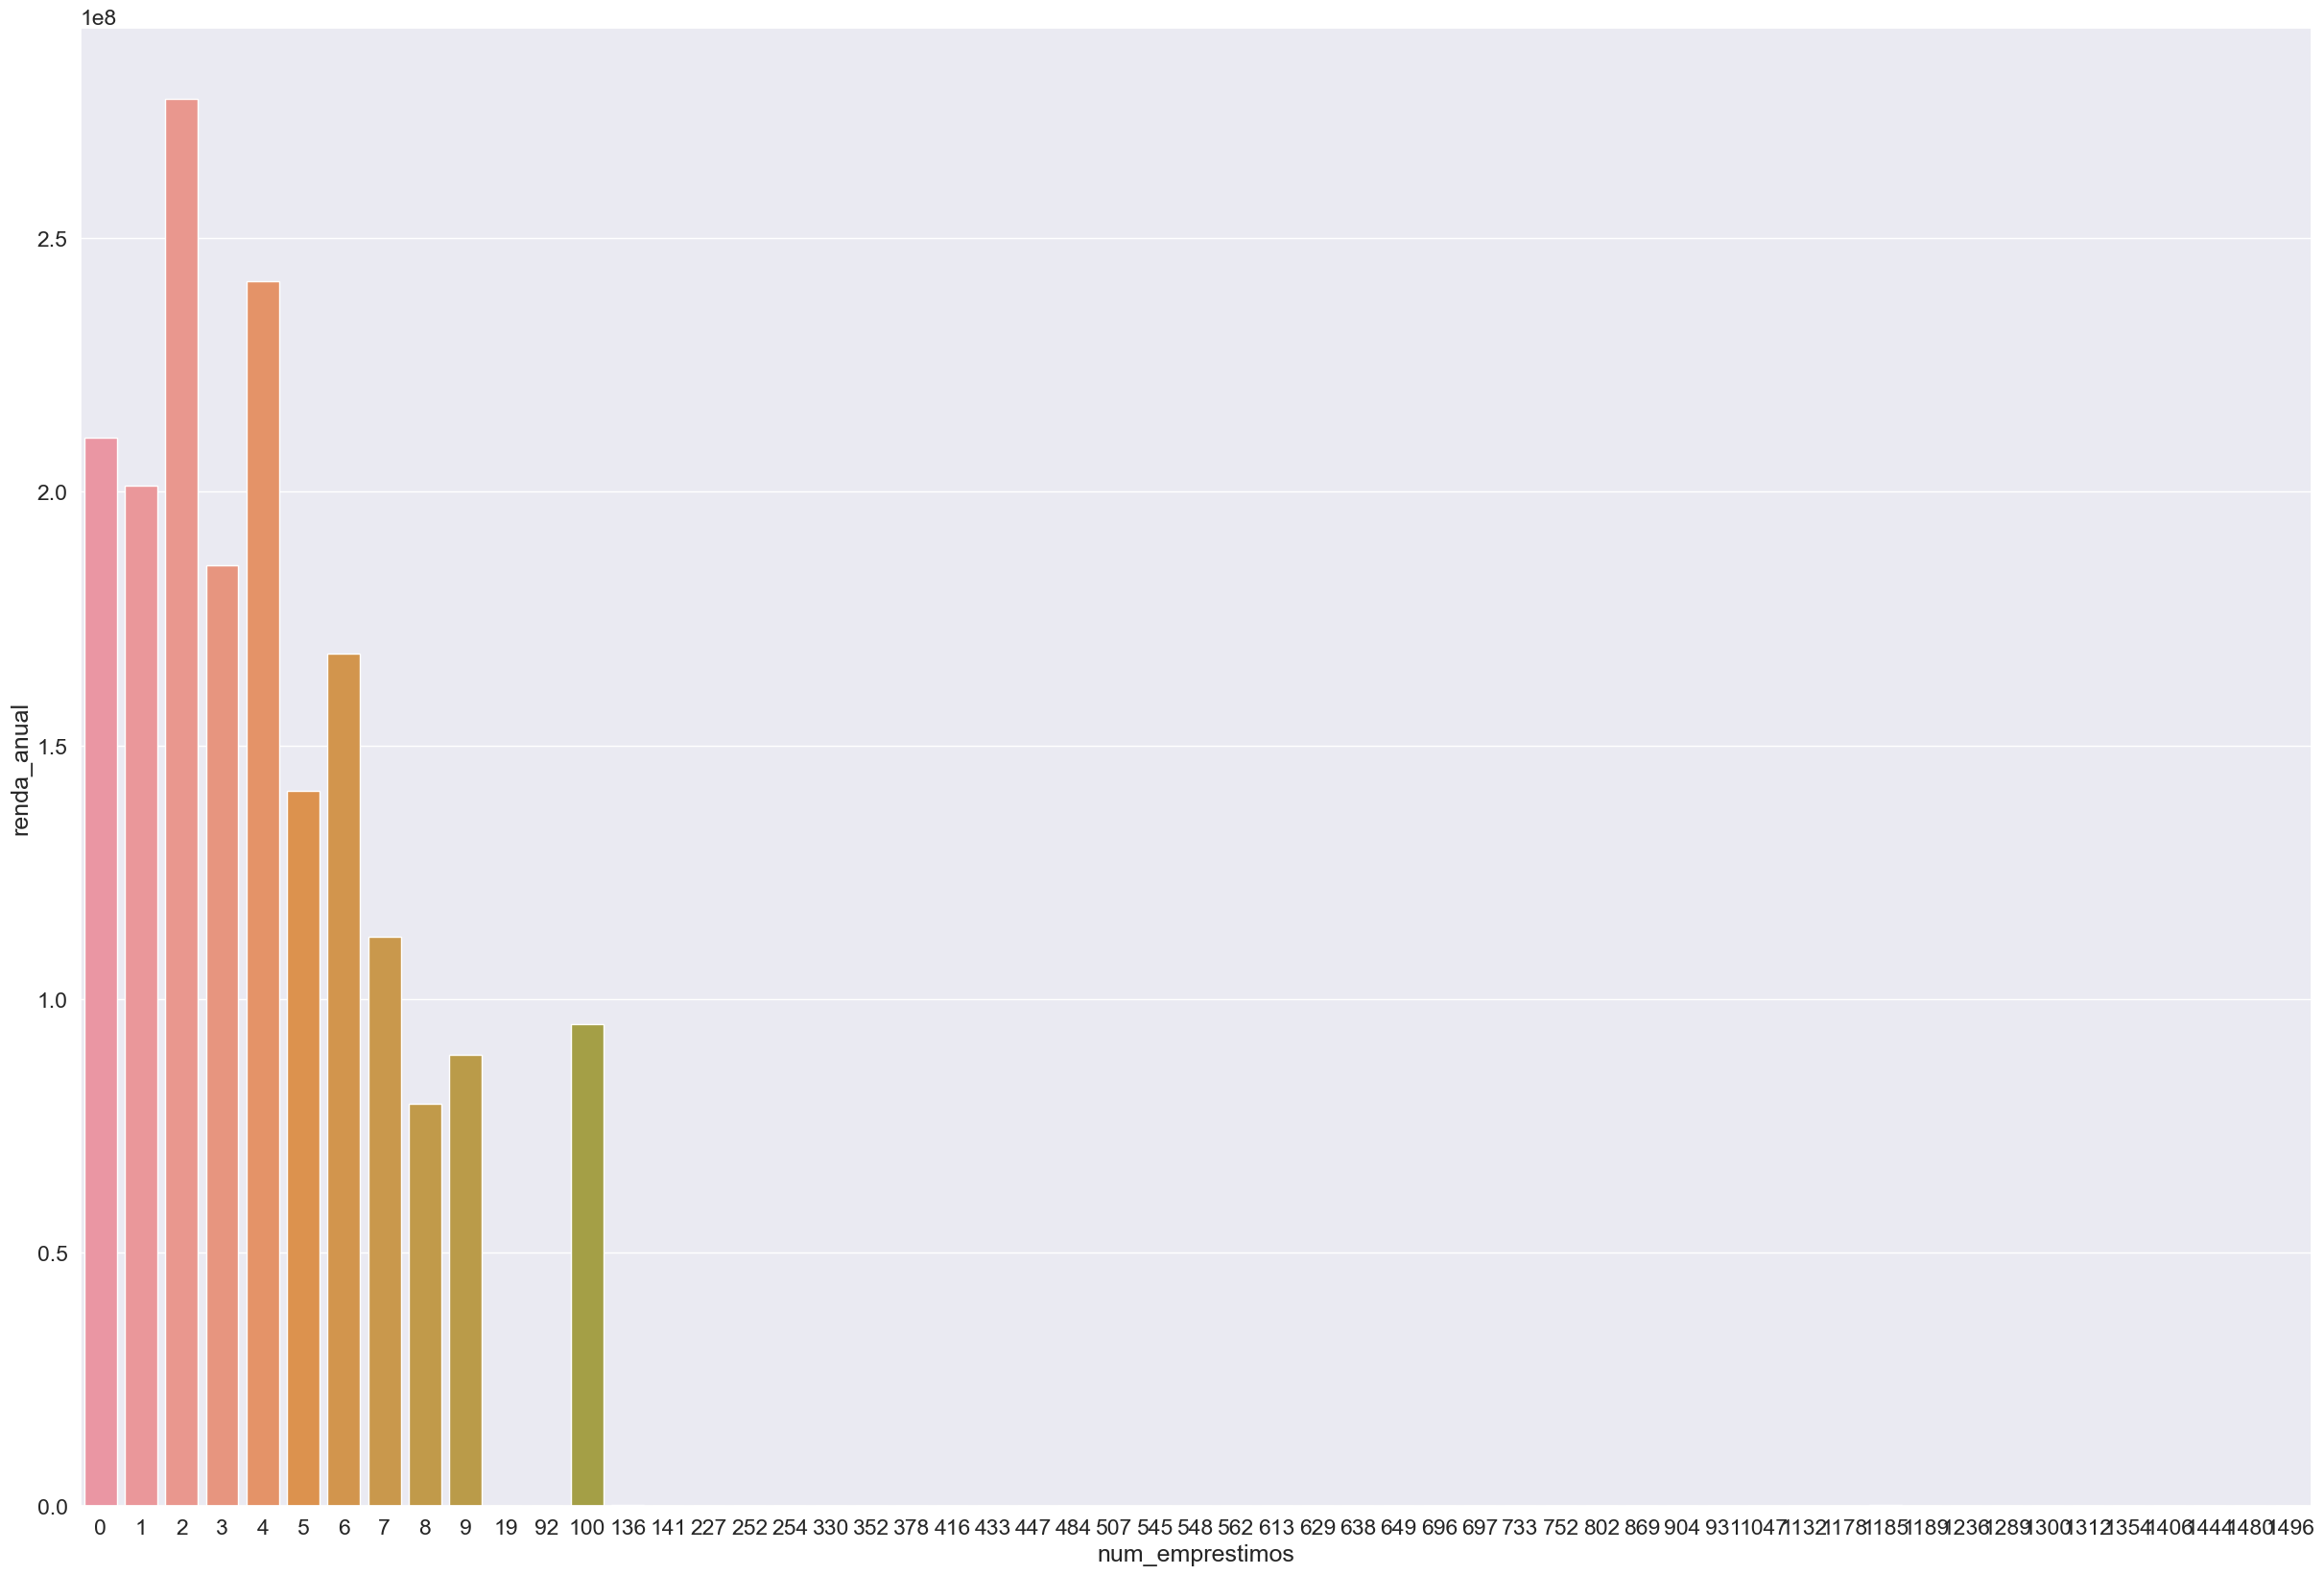

In [37]:
aux1 = df4[['num_emprestimos', 'renda_anual']].groupby( 'num_emprestimos' ).sum().reset_index()
sns.barplot( x='num_emprestimos', y='renda_anual', data=aux1 );

### H5 - Clientes com maior solicitação de limite de crédito possuem maior dívida 
 - Hipótese verdadeira, pois clientes que possuem maior dívida são aqueles que solicitam maior crédito. 

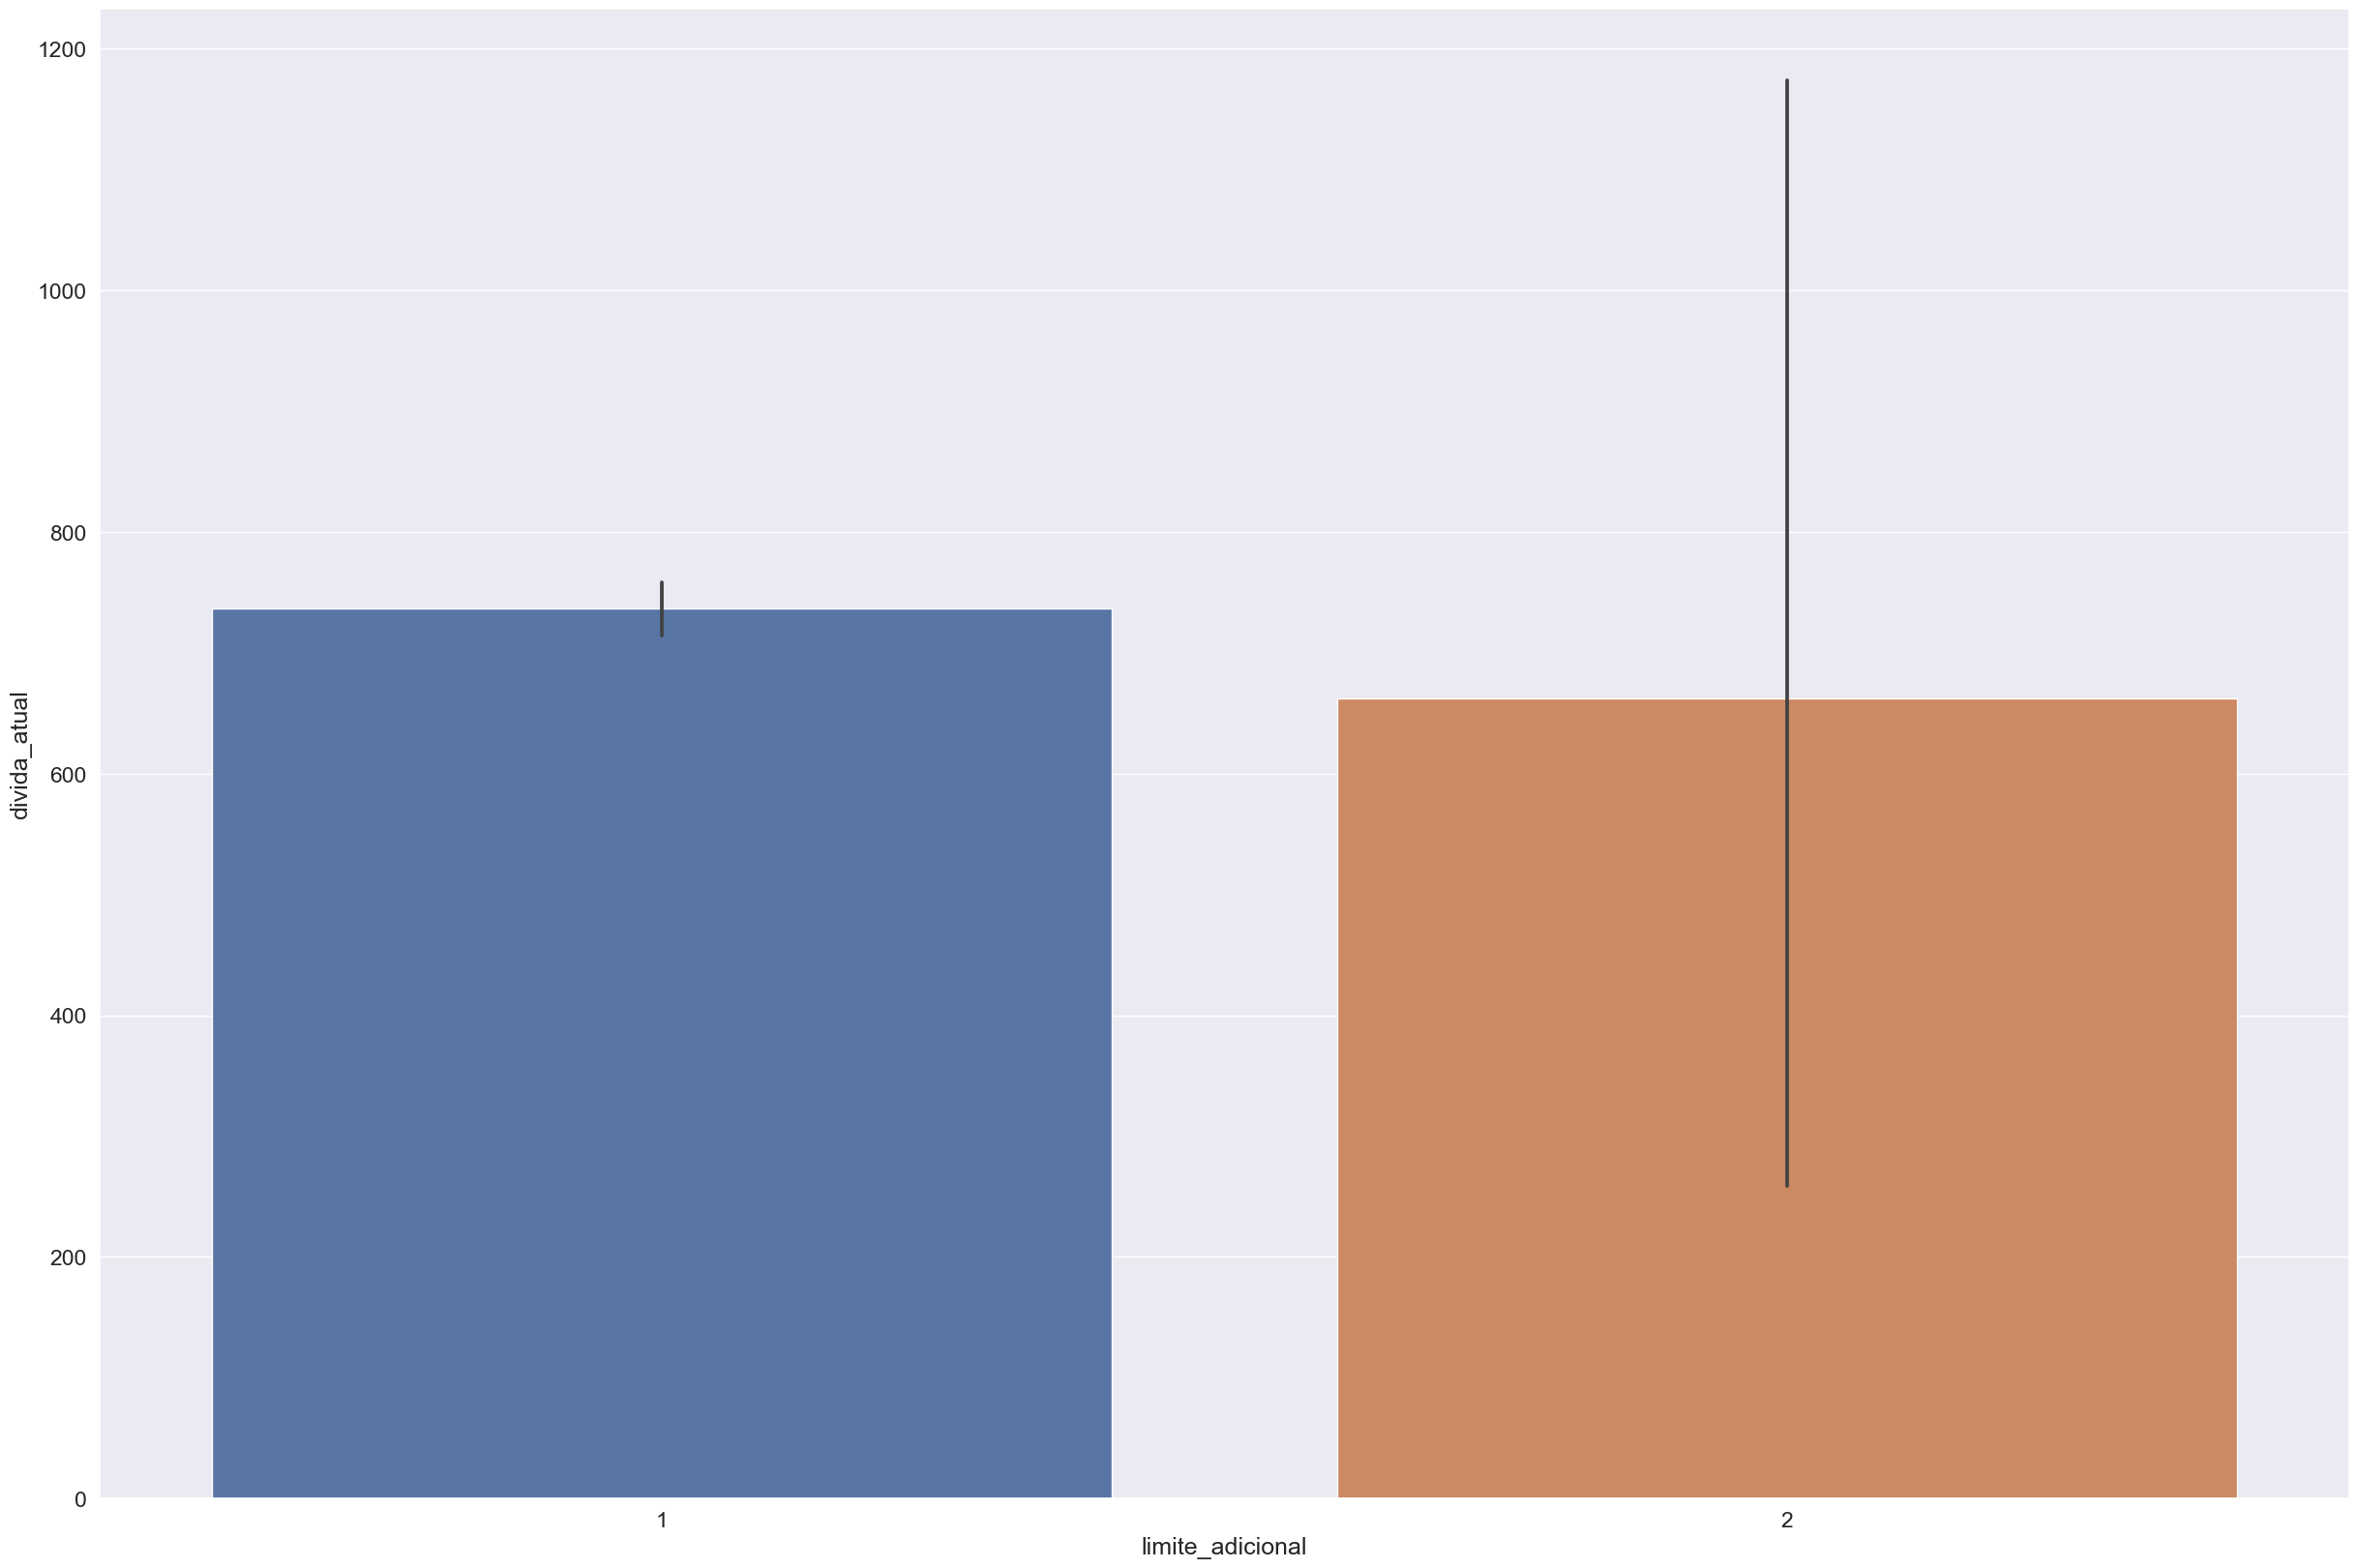

In [38]:
aux1 = df4[df4['limite_adicional']==0].groupby( 'divida_atual' ).count().reset_index()
aux1 = df4[df4['limite_adicional']==1].groupby( 'divida_atual' ).count().reset_index()
sns.barplot( x='limite_adicional', y='divida_atual', data=aux1 );

## 3.3 Multivariate Analysis

### 3.3.1 Numerical attributes

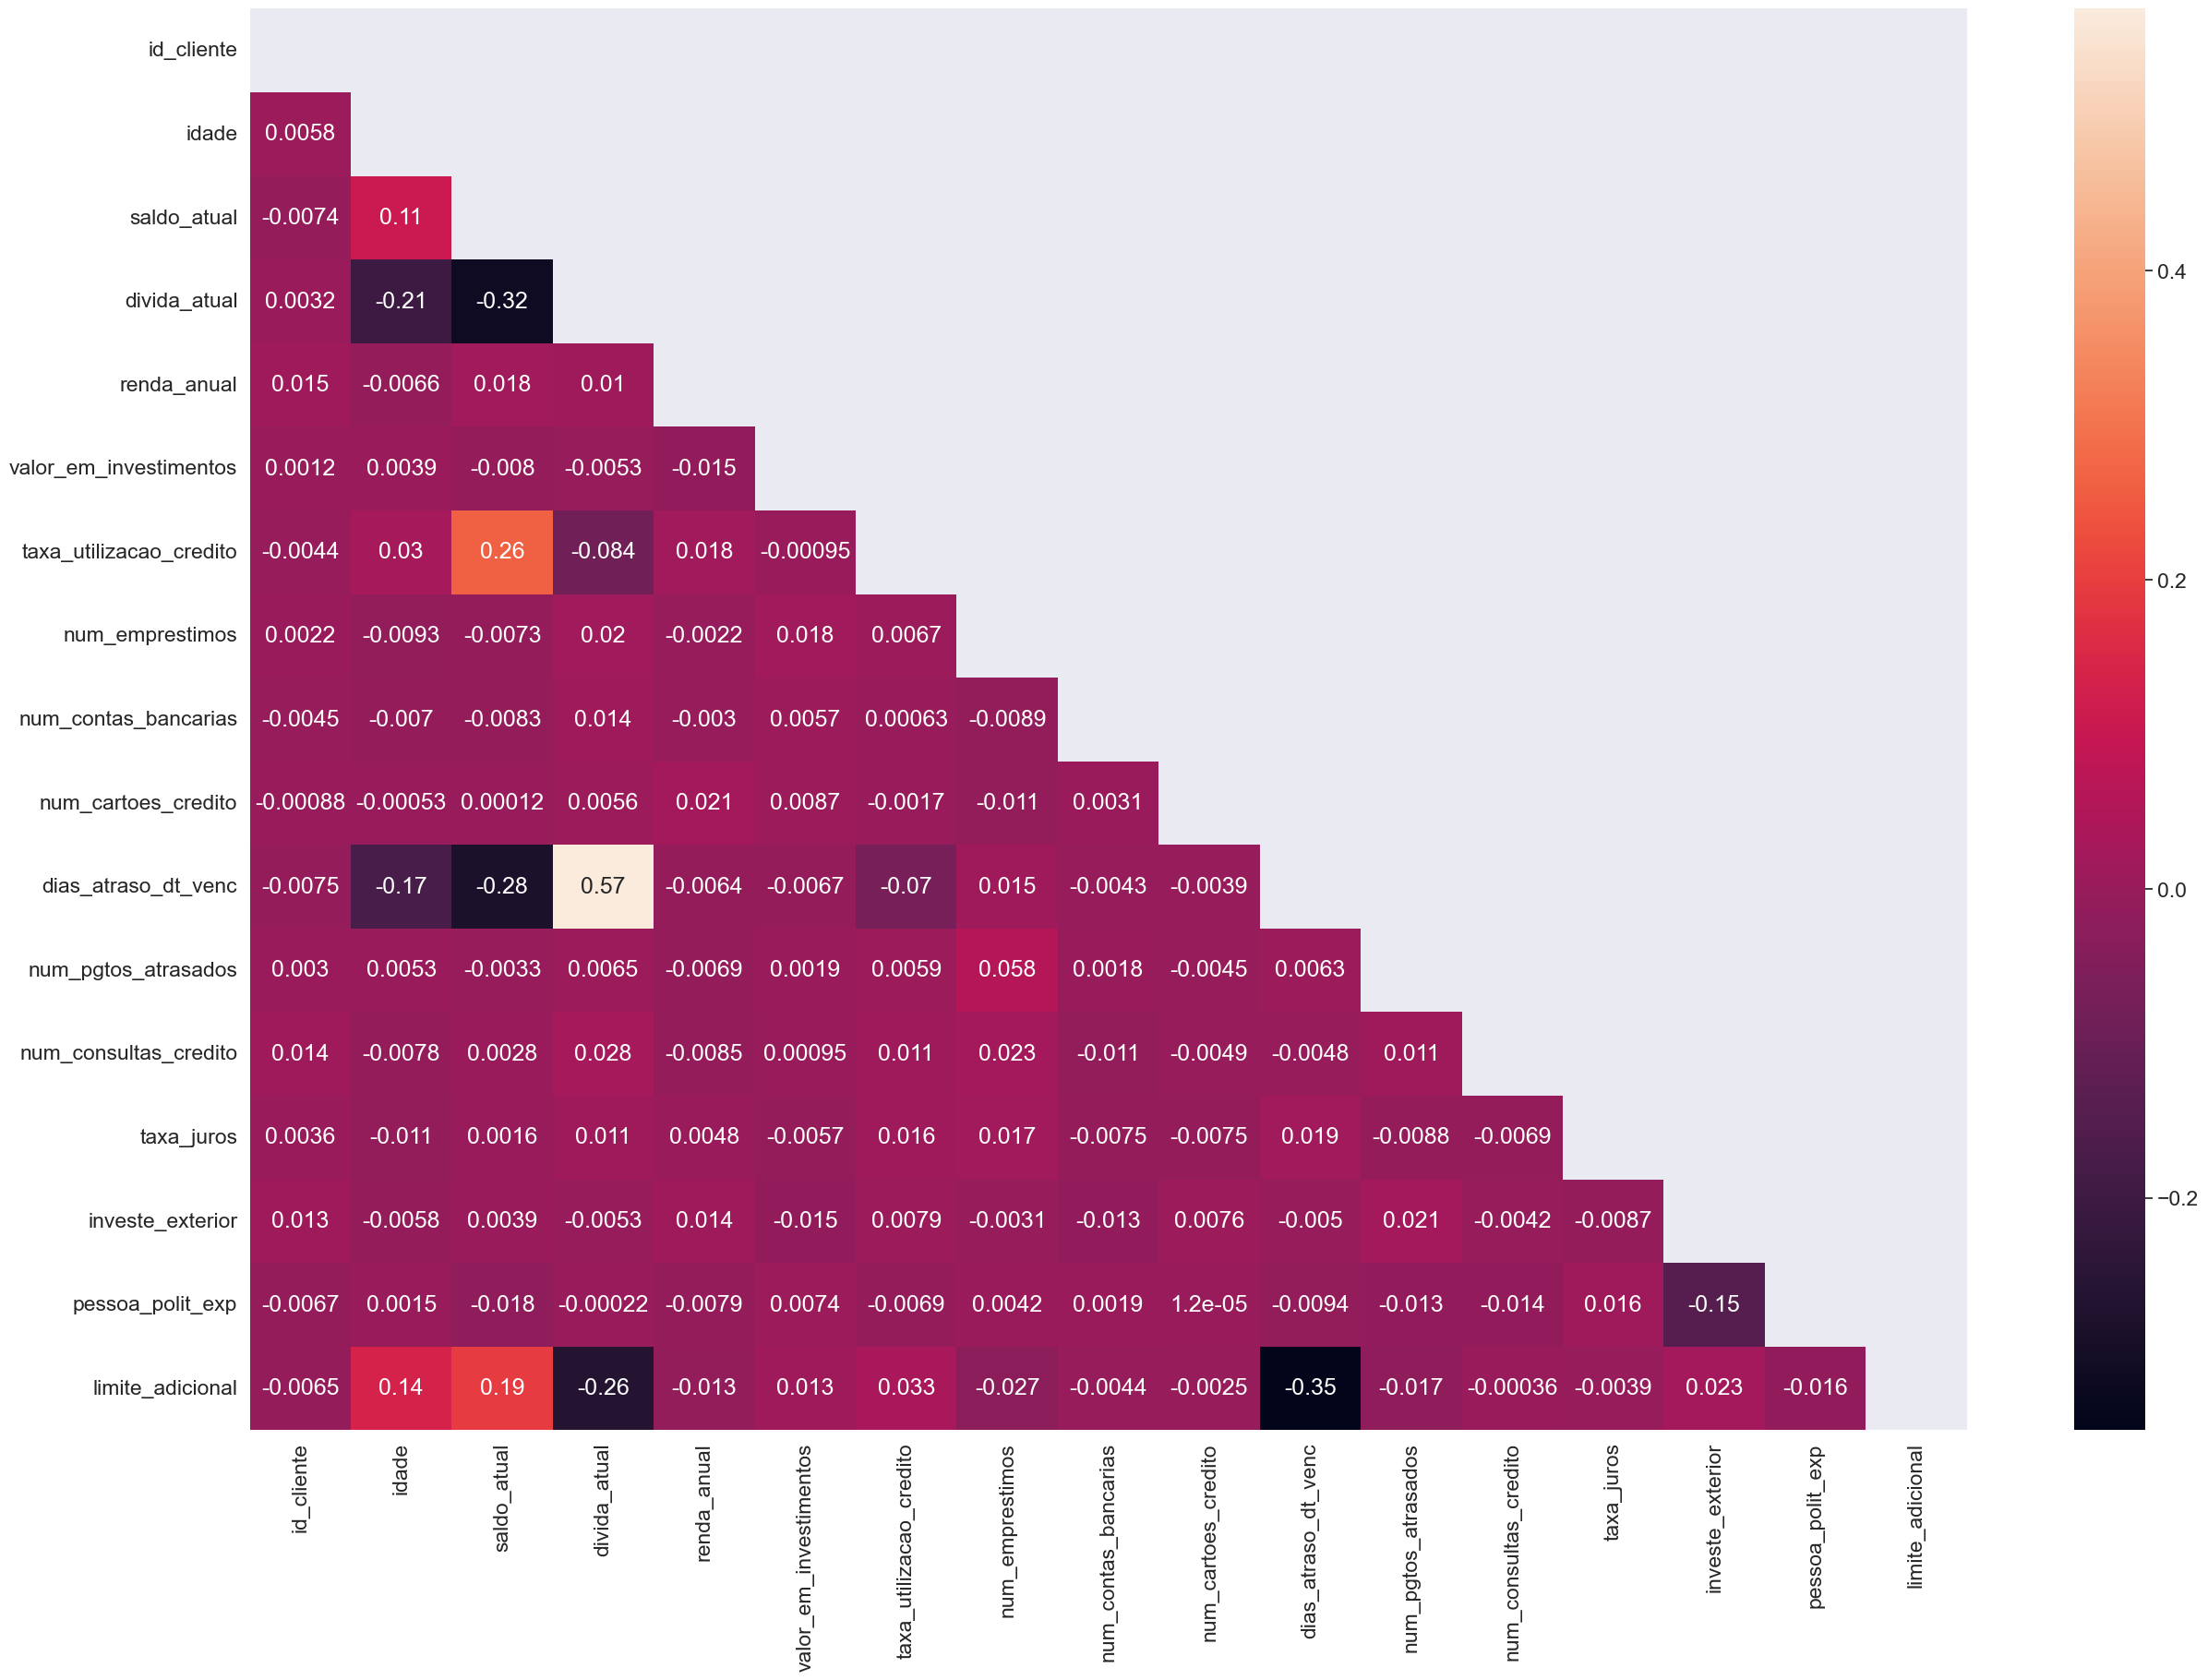

In [39]:
correlation = num_df5.corr( method='pearson' )
corr_mask = np.triu(correlation)
sns.heatmap( correlation, annot=True, mask=corr_mask );


# 4.0 Data Balance

In [40]:
df6 = df5.copy()

In [41]:
#  proportion conceder
df6[df6['limite_adicional']==1].shape[0] / df6.shape[0]

0.15759219088937093

## 4.1 Testando Oversampling

In [42]:
# proportion parameter
param = df6['limite_adicional'].value_counts().to_dict()

In [43]:
7767/1453

5.345492085340674

In [44]:
param = {0: 7767, 1: 1453*5}
param

{0: 7767, 1: 7265}

In [45]:
# oversampling

# definindo
smt = c.SMOTETomek(sampling_strategy=param , random_state=42, n_jobs=1)

# aplicando
x_smt, y_smt = smt.fit_resample(df6, df6['limite_adicional'])


In [46]:
x_smt['limite_adicional'].value_counts()

0    7435
1    6933
Name: limite_adicional, dtype: int64

In [47]:
6933/(7435+6933)

0.4825306236080178

In [48]:
df6 = x_smt
df6.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,"2,577.05","24,196.90",104.31,31.04,6,5,7,21,14,9,15,0,0,0
1,11920,40,268.87,"2,465.39","19,227.38",69.86,36.92,5,8,5,40,23,10,18,0,0,0
2,8910,36,446.64,"1,055.29","42,822.28",134.20,34.56,0,3,6,26,13,3,15,1,0,0
3,4964,58,321.14,703.05,"51,786.83",297.35,31.49,0,3,7,12,7,2,1,1,0,0
4,10100,35,428.72,891.29,"44,626.85",134.20,28.03,2,8,7,24,10,8,20,1,0,0


# 5.0 Data Preparation

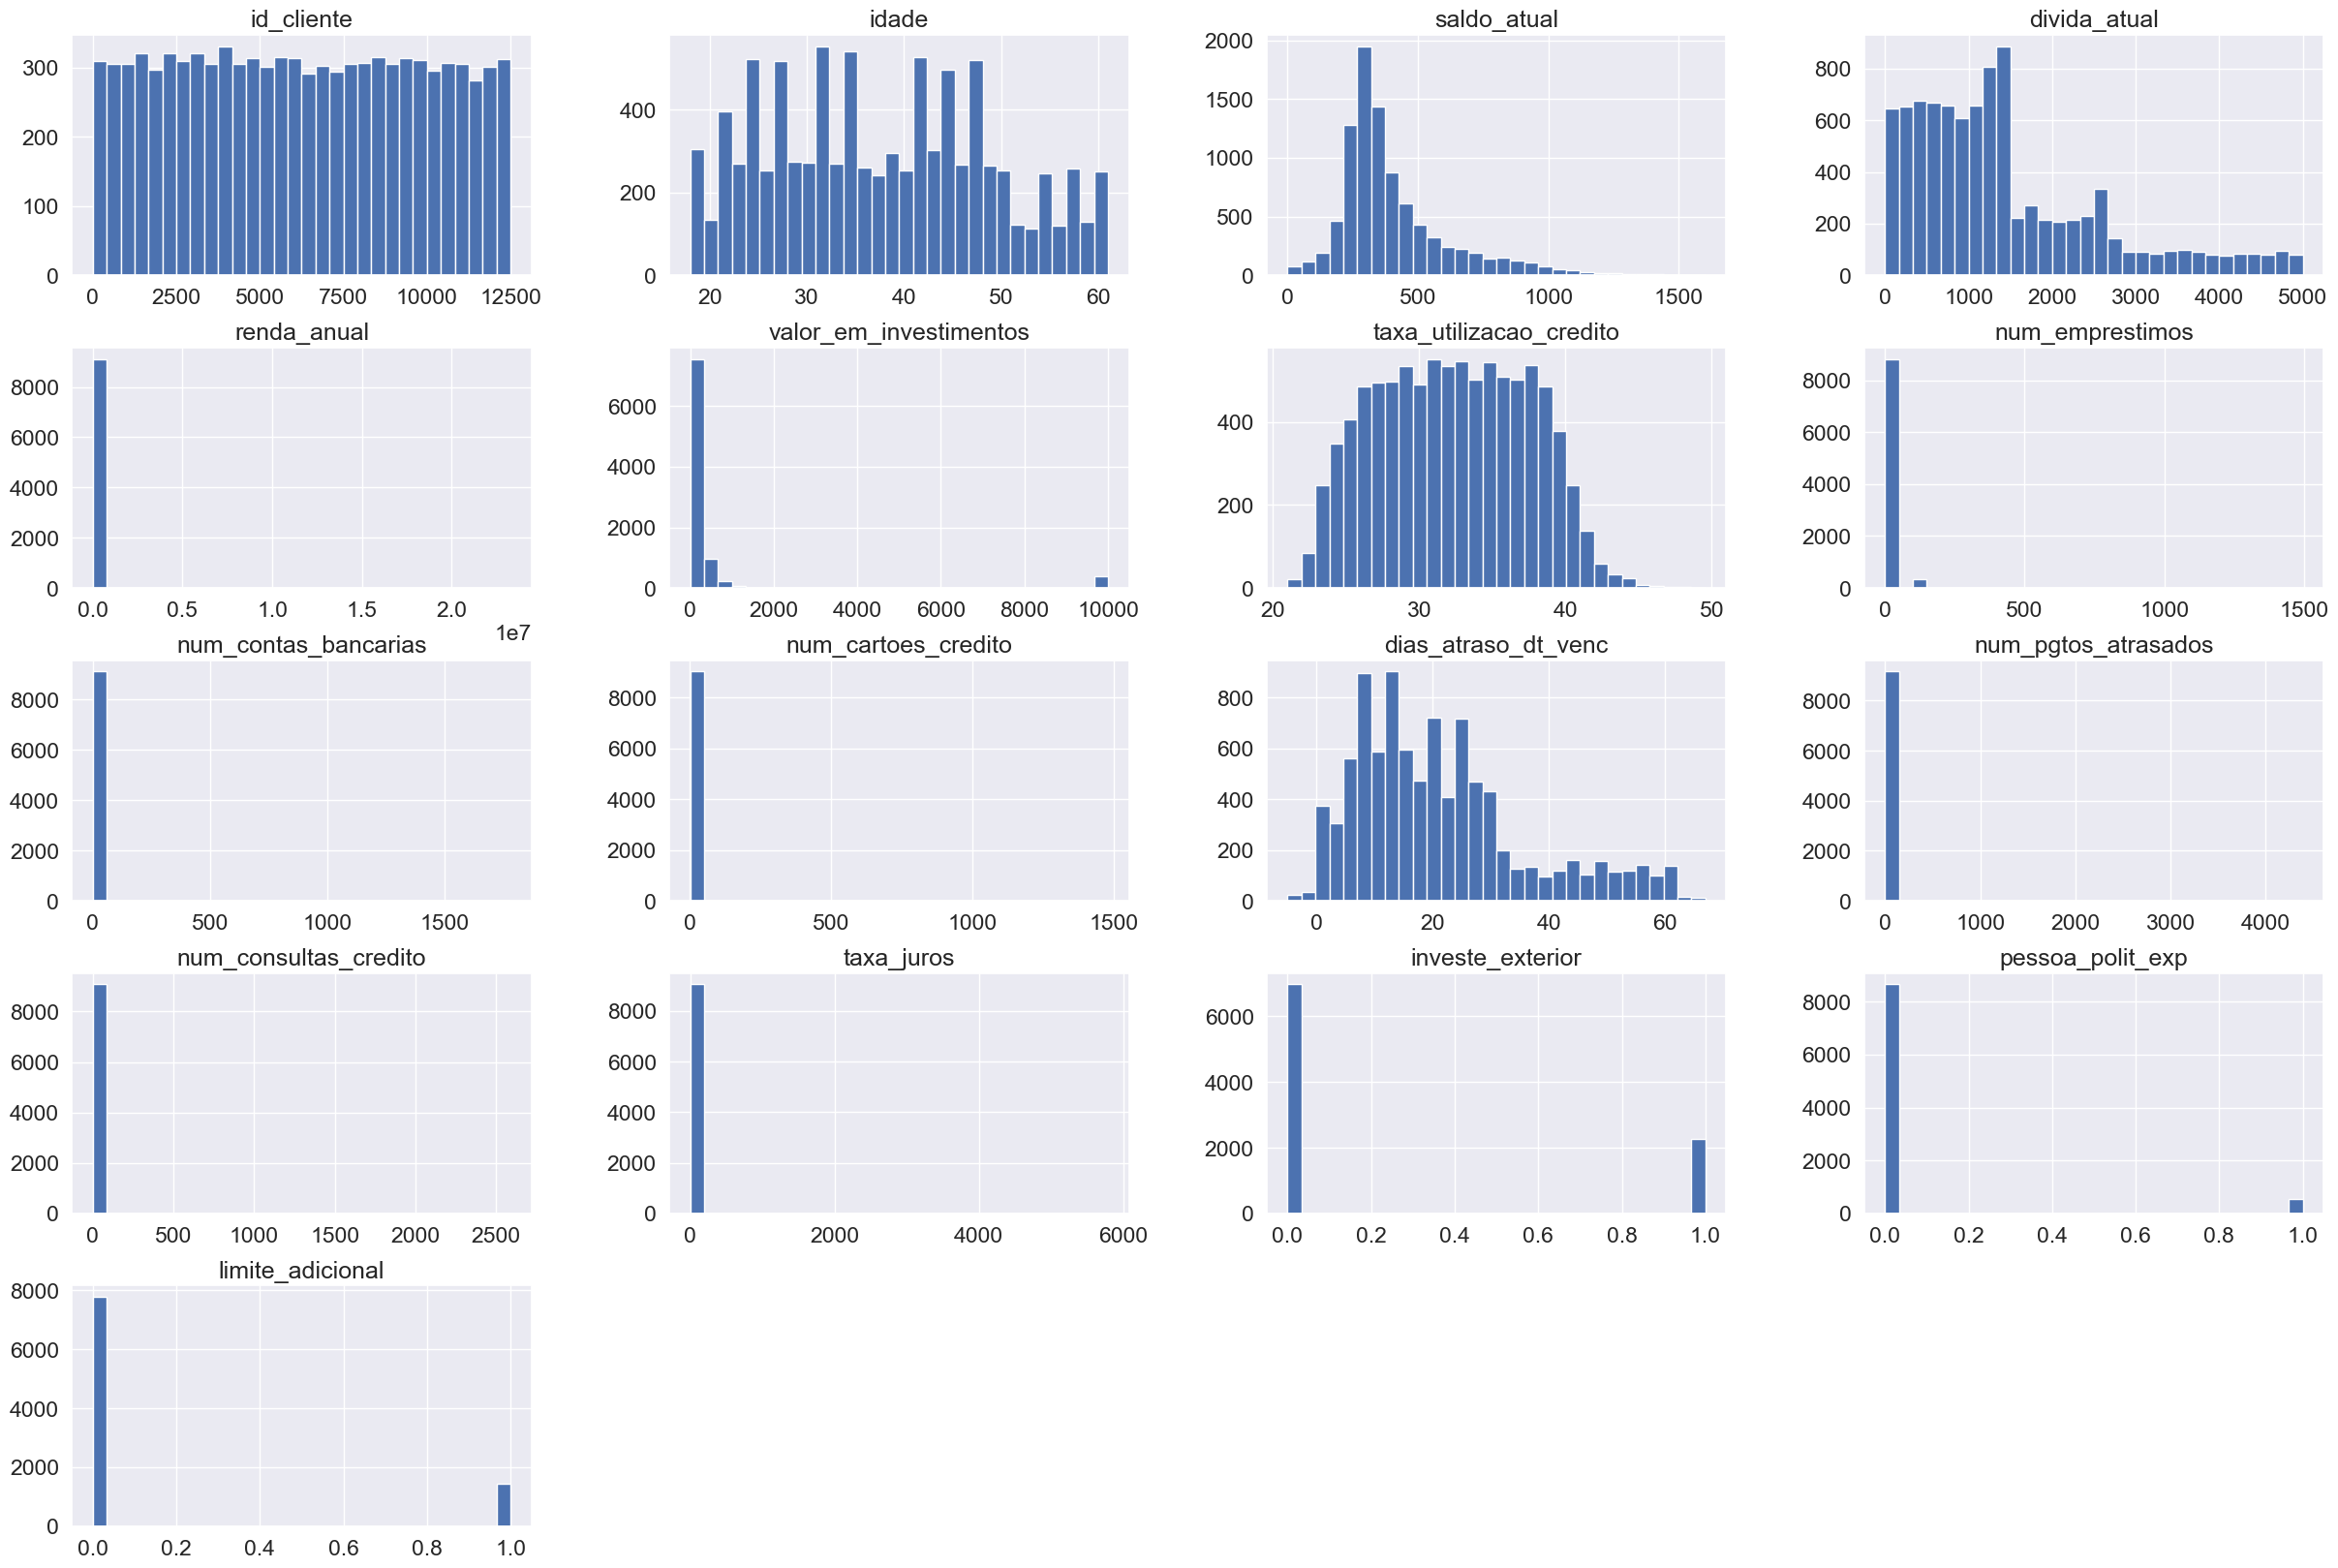

In [49]:
plt.rcParams['figure.figsize'] = [30, 20]
num_df5.hist(bins=30);
personal_settings()

In [50]:
df7 = df6.copy()

In [51]:
# Rescaling

# MinMax Scaler - não muda a forma da normal, mas é sensível a outliers
mms = MinMaxScaler()

#idade
df7['idade'] = mms.fit_transform(df7[['idade']].values)
pickle.dump(mms, open('parameter/rescaling_idade.pkl', 'wb'))

In [52]:
# Robust Scaler - tira a dependência do outlier, mas cria um range menor
rs = RobustScaler()

# saldo atual
df7['saldo_atual'] = mms.fit_transform(df7[['saldo_atual']].values)
pickle.dump(mms, open('parameter/rescaling_saldo_atual.pkl', 'wb'))

# divida atual
df7['divida_atual'] = mms.fit_transform(df7[['divida_atual']].values)
pickle.dump(mms, open('parameter/rescaling_divida_atual.pkl', 'wb'))

# renda anual
df7['renda_anual'] = mms.fit_transform(df7[['renda_anual']].values)
pickle.dump(mms, open('parameter/rescaling_renda_anual.pkl', 'wb'))

# valor em investimentos
df7['valor_em_investimentos'] = mms.fit_transform(df7[['valor_em_investimentos']].values)
pickle.dump(mms, open('parameter/rescaling_valor_em_investimentos.pkl', 'wb'))

# valor em investimentos
df7['taxa_utilizacao_credito'] = mms.fit_transform(df7[['taxa_utilizacao_credito']].values)
pickle.dump(mms, open('parameter/rescaling_taxa_utilizacao_credito.pkl', 'wb'))

# num_emprestimos
df7['num_emprestimos'] = mms.fit_transform(df7[['num_emprestimos']].values)
pickle.dump(mms, open('parameter/rescaling_num_emprestimos.pkl', 'wb'))

# num_contas_bancarias
df7['num_contas_bancarias'] = mms.fit_transform(df7[['num_contas_bancarias']].values)
pickle.dump(mms, open('parameter/rescaling_num_contas_bancarias.pkl', 'wb'))

# num_cartoes_credito
df7['num_cartoes_credito'] = mms.fit_transform(df7[['num_cartoes_credito']].values)
pickle.dump(mms, open('parameter/rescaling_num_cartoes_credito.pkl', 'wb'))

# dias_atraso_dt_venc
df7['dias_atraso_dt_venc'] = mms.fit_transform(df7[['dias_atraso_dt_venc']].values)
pickle.dump(mms, open('parameter/rescaling_dias_atraso_dt_venc.pkl', 'wb'))

# num_pgtos_atrasados
df7['num_pgtos_atrasados'] = mms.fit_transform(df7[['num_pgtos_atrasados']].values)
pickle.dump(mms, open('parameter/rescaling_num_pgtos_atrasados.pkl', 'wb'))

# num_consultas_credito
df7['num_consultas_credito'] = mms.fit_transform(df7[['num_consultas_credito']].values)
pickle.dump(mms, open('parameter/rescaling_num_consultas_credito.pkl', 'wb'))

# taxa_juros
df7['taxa_juros'] = mms.fit_transform(df7[['taxa_juros']].values)
pickle.dump(mms, open('parameter/rescaling_taxa_juros.pkl', 'wb'))

# investe_exterior
df7['investe_exterior'] = mms.fit_transform(df7[['investe_exterior']].values)
pickle.dump(mms, open('parameter/rescaling_investe_exterior.pkl', 'wb'))

In [53]:
df7.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,0.07,0.17,0.52,0.00,0.01,0.35,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0,0
1,11920,0.51,0.17,0.49,0.00,0.01,0.56,0.00,0.00,0.00,0.62,0.01,0.00,0.00,0.00,0,0
2,8910,0.42,0.28,0.21,0.00,0.01,0.47,0.00,0.00,0.00,0.43,0.00,0.00,0.00,1.00,0,0
3,4964,0.93,0.20,0.14,0.00,0.03,0.37,0.00,0.00,0.00,0.24,0.00,0.00,0.00,1.00,0,0
4,10100,0.40,0.27,0.18,0.00,0.01,0.25,0.00,0.00,0.00,0.40,0.00,0.00,0.00,1.00,0,0


# 6.0 Feature Selection

In [54]:
df8 = df7.copy()
#df8.head()

In [55]:
# separando o df em treino e validação
X = df8
Y = df8['limite_adicional'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, Y, test_size=0.20)

## Boruta Feature Selection

In [56]:
# # df de treino para o Boruta
# X_train_blist = x_train.drop(['id_cliente', 'limite_adicional'], axis=1).values # array
# Y_train_blist = y_train.values #array

# # definindo Random Forest
# rf = RandomForestRegressor(n_jobs=-1) # processamento paralelo

# # definindo o Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_blist, Y_train_blist)

In [57]:
# cols_selected_boruta
# ['id_cliente',
#  'idade',
#  'saldo_atual',
#  'divida_atual',
#  'renda_anual',
#  'valor_em_investimentos',
#  'taxa_utilizacao_credito',
#  'num_contas_bancarias',
#  'num_cartoes_credito',
#  'dias_atraso_dt_venc',
#  'num_pgtos_atrasados',
#  'num_consultas_credito',
#  'taxa_juros']

In [58]:
# cols_selected_blist = boruta.support_.tolist() # colunas selecionadas pelo boruta
# X_train_FS = x_train.drop(['id_cliente', 'limite_adicional'], axis=1)

# cols_selected_boruta_v3 = X_train_FS.iloc[:,cols_selected_blist].columns.to_list() # lista de colunas boruta

# cols_selected_boruta_v3

In [59]:
# cols_selected_blist = boruta.support_.tolist() # colunas selecionadas pelo boruta
# X_train_FS = x_train.drop(['id_cliente', 'limite_adicional'], axis=1)

# cols_selected_boruta_v4 = X_train_FS.iloc[:,cols_selected_blist].columns.to_list() # lista de colunas boruta

# cols_selected_boruta_v4

In [60]:
# cols_selected_blist = boruta.support_.tolist() # colunas selecionadas pelo boruta
# X_train_FS = x_train.drop(['id_cliente', 'limite_adicional'], axis=1)

# cols_selected_boruta_v5 = X_train_FS.iloc[:,cols_selected_blist].columns.to_list() # lista de colunas boruta

# cols_selected_boruta_v5

In [61]:
#       dias_atraso_dt_venc        0.24
#              divida_atual        0.15
#                taxa_juros        0.07
#       num_pgtos_atrasados        0.07
#                     idade        0.06
#     num_consultas_credito        0.06
#      num_contas_bancarias        0.06
#               saldo_atual        0.05

In [62]:
# Features Selected from Boruta
cols_selected_boruta = [
    'idade',
    'saldo_atual',
    'divida_atual',
    'renda_anual', # tirar
    'valor_em_investimentos', # tirar
    'taxa_utilizacao_credito',
    'num_contas_bancarias',
    'num_cartoes_credito', # tirar
    'dias_atraso_dt_venc',
    'num_pgtos_atrasados',
    'num_consultas_credito',
    'taxa_juros'
    ]


# features to add
features_added = ['id_cliente', 'limite_adicional']

# final features
cols_selected_boruta_plus = [
    'id_cliente',
    'idade',
    'saldo_atual',
    'divida_atual',
    'renda_anual',
    'valor_em_investimentos',
    'taxa_utilizacao_credito',
    'num_contas_bancarias',
    'num_cartoes_credito',
    'dias_atraso_dt_venc',
    'num_pgtos_atrasados',
    'num_consultas_credito',
    'taxa_juros',
    'limite_adicional']

cols_selected_boruta

['idade',
 'saldo_atual',
 'divida_atual',
 'renda_anual',
 'valor_em_investimentos',
 'taxa_utilizacao_credito',
 'num_contas_bancarias',
 'num_cartoes_credito',
 'dias_atraso_dt_venc',
 'num_pgtos_atrasados',
 'num_consultas_credito',
 'taxa_juros']

## Importance Feature Selection

In [63]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = x_train.drop(['id_cliente', 'limite_adicional'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n);

In [64]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
 
# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
     
print( df.sort_values( 'importance', ascending=False ) )

Feature ranking:
                   feature  importance
0      dias_atraso_dt_venc        0.23
0             divida_atual        0.15
0      num_pgtos_atrasados        0.07
0               taxa_juros        0.07
0                    idade        0.06
0    num_consultas_credito        0.06
0     num_contas_bancarias        0.05
0              saldo_atual        0.05
0      num_cartoes_credito        0.05
0          num_emprestimos        0.04
0              renda_anual        0.04
0  taxa_utilizacao_credito        0.04
0   valor_em_investimentos        0.04
0         investe_exterior        0.02
0         pessoa_polit_exp        0.02


## Manual Feature Selection

In [65]:
cols_selected_boruta = [
 'idade',
 'saldo_atual',
 'divida_atual',
 'renda_anual',
 'valor_em_investimentos',
 'taxa_utilizacao_credito',
 'num_contas_bancarias',
 'num_cartoes_credito',
 'dias_atraso_dt_venc',
 'num_pgtos_atrasados',
 'num_consultas_credito',
 'taxa_juros']

# 7.0 Machine Learning

In [66]:
# X_train com colunas selecionadas pelo Boruta
x_train_colsb = x_train[cols_selected_boruta] 

# X_validation com colunas selecionadas pelo Boruta
x_val_colsb = x_val[cols_selected_boruta]

## 7.1 Dummy Classifier (baseline)

In [67]:
# model definition
dm_model = dummy.DummyClassifier(strategy = 'uniform')

# model training
dm_model.fit(x_train_colsb, y_train)

# model prediction
yhat_dm = dm_model.predict(x_val_colsb)

# performance  
dm_result = f1_score(y_val, yhat_dm)
print('f1 score', dm_result)

# # cross validation
# dm_cv = cross_val_score(dm_model, x_train_colsb, y_train, cv=5)
# print('cross validation\n', dm_cv)

# print('cv média', np.mean(dm_cv))
# print('cv desv.', np.std(dm_cv))

f1 score 0.4838135894699395


## 7.2 Logistic Regression

In [68]:
# model
lr = LogisticRegression().fit(x_train_colsb, y_train)

# creating prediction
yhat_lr = lr.predict(x_val_colsb) # ŷ -> predicted value

# performance
lr_result = f1_score(y_val, yhat_lr)
print('f1 score', lr_result)

# # cross validation
# lr_cv = cross_val_score(lr, x_train_colsb, y_train, cv=5)
# print('cross validation\n', lr_cv)

# print('cv média', np.mean(lr_cv))
# print('cv desv.', np.std(lr_cv))

f1 score 0.7956058588548601


## 7.3 XGboost

In [69]:
# model
xgbm = xgb.XGBClassifier(objective='reg:squarederror',
                        n_estimators=1000, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

# # cross validation
# xgbm_cv = cross_val_score(xgbm, x_train_colsb, y_train, cv=5)
# print('cross validation\n', xgbm_cv)

# print('cv média', np.mean(xgbm_cv))
# print('cv desv.', np.std(xgbm_cv))

f1 score 0.918732782369146


In [70]:
# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1000, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

# # cross validation
# xgbm_cv = cross_val_score(xgbm, x_train_colsb, y_train, cv=5)
# print('cross validation\n', xgbm_cv)

# print('cv média', np.mean(xgbm_cv))
# print('cv desv.', np.std(xgbm_cv))

f1 score 0.9199447895100069


## 7.4 Random Forest Regressor

In [71]:
# model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_colsb, y_train)

# creating prediction
yhat_rf = rf.predict(x_val_colsb) # ŷ -> predicted value

# performance

# performance
rf_result = f1_score(y_val, yhat_rf)
print('f1 score', rf_result)

# # cross validation
# rf_cv = cross_val_score(rf, x_train_colsb, y_train, cv=5)
# print('cross validation\n', rf_cv)

# print('cv média', np.mean(rf_cv))
# print('cv desv.', np.std(rf_cv))

f1 score 0.9171232876712329


## 7.5 Models Performance Comparison

In [72]:
print(np.mean(dm_result), 'Dummy')

print(np.mean(lr_result), 'Logistic Regression')

print(np.mean(xgbm_result), 'XGBoost')

print(np.mean(rf_result), 'Random Forest')

0.4838135894699395 Dummy
0.7956058588548601 Logistic Regression
0.9199447895100069 XGBoost
0.9171232876712329 Random Forest


In [73]:
# versão COM balanceamento, COM ecoding, sem fine tuning, com 8 features
v5 = pd.DataFrame({'Model Name': ['Dummy', 'LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [np.mean(dm_result), np.mean(lr_result), np.mean(xgbm_result), np.mean(rf_result)]
                      })
v5.sort_values('Score', ascending=False)

,Model Name,Score
2,Xgboost,0.92
3,Random Forest,0.92
1,LogisticRegression,0.80
0,Dummy,0.48


In [74]:
# versão COM balanceamento, COM ecoding, sem fine tuning
v4 = pd.DataFrame({'Model Name': ['Dummy', 'LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [np.mean(dm_result), np.mean(lr_result), np.mean(xgbm_result), np.mean(rf_result)]
                      })
v4.sort_values('Score', ascending=False)

,Model Name,Score
2,Xgboost,0.92
3,Random Forest,0.92
1,LogisticRegression,0.80
0,Dummy,0.48


In [76]:
# versão COM balanceamento, sem ecoding, sem fine tuning
# v2 = pd.DataFrame({'Model Name': ['Dummy', 'LogisticRegression', 'Xgboost', 'Random Forest'],
#                      'Score': [np.mean(dm_cv), np.mean(lr_cv), np.mean(xgbm_cv), np.mean(rf_cv)]
#                      })
#v2.sort_values('Score', ascending=False)

In [77]:
# versão sem balanceamento, sem ecoding, sem fine tuning
# v1 = pd.DataFrame({'Model Name': ['Dummy', 'LogisticRegression', 'Xgboost', 'Random Forest'],
#                     'Score': [np.mean(dm_cv), np.mean(lr_cv), np.mean(xgbm_cv), np.mean(rf_cv)]
#                     })
#v1.sort_values('Score', ascending=False)

## 7.6 Cross Validation

In [78]:
x_train_allcols = x_train[cols_selected_boruta_plus]

In [79]:
lr_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Logistic Regression', lr, verbose=True)


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1
[0.7956058588548601, 0.7956058588548601, 0.7956058588548601, 0.7956058588548601, 0.7956058588548601]
            Model Name  F1 Score Mean
0  Logistic Regression           0.80


In [80]:
x_val_selected = x_val[cols_selected_boruta]
x_val_selected.shape
#y_val_selected = y_val[cols_selected_boruta]

(2874, 12)

In [81]:
xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val_selected, y_val, 5, 'Xgboost', xgbm, verbose=True)


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1
[0.9199447895100069, 0.9199447895100069, 0.9199447895100069, 0.9199447895100069, 0.9199447895100069]
  Model Name  F1 Score Mean
0    Xgboost           0.92


In [82]:
rf_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'RandomForest', rf, verbose=True)


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1
[0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329]
     Model Name  F1 Score Mean
0  RandomForest           0.92


In [83]:
# versão COM balanceamento, COM ecoding, SEM fine tuning, COM xgboost binary hinge, COM 8 features
cv6 = pd.DataFrame({'Model Name': ['LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [lr_result_cv, xgbm_result_cv, rf_result_cv]
                      })
cv6.sort_values('Score', ascending=False)

,Model Name,Score
1,Xgboost,0.92
2,Random Forest,0.92
0,LogisticRegression,0.80


In [84]:
# versão COM balanceamento, COM ecoding, SEM fine tuning, COM xgboost binary hinge
cv5 = pd.DataFrame({'Model Name': ['LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [lr_result_cv, xgbm_result_cv, rf_result_cv]
                      })
cv5.sort_values('Score', ascending=False)

,Model Name,Score
1,Xgboost,0.92
2,Random Forest,0.92
0,LogisticRegression,0.80


In [85]:
# versão COM balanceamento, COM ecoding, SEM fine tuning
cv3 = pd.DataFrame({'Model Name': ['LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [lr_result_cv, xgbm_result_cv, rf_result_cv]
                      })
cv3.sort_values('Score', ascending=False)

,Model Name,Score
1,Xgboost,0.92
2,Random Forest,0.92
0,LogisticRegression,0.80


In [86]:
# versão COM balanceamento, COM ecoding, SEM fine tuning, COM filtragem de outliers
cv4 = pd.DataFrame({'Model Name': ['LogisticRegression', 'Xgboost', 'Random Forest'],
                      'Score': [lr_result_cv, xgbm_result_cv, rf_result_cv]
                      })
cv4.sort_values('Score', ascending=False)

,Model Name,Score
1,Xgboost,0.92
2,Random Forest,0.92
0,LogisticRegression,0.80


# 8.0 Hyper Parameter Fine Tuning

In [87]:
df9 = df8.copy()

## 8.1 Random Forest Tuned

In [88]:
rf_param_dict = { 'max_depth': [20, 40, 60],
                  'min_samples_leaf': [200, 500,1000, 1500],
                  'n_estimators': [100, 300, 500, 1000]}

interations = 5

final_result = pd.DataFrame()
hyperparam_list = []

for i in range(interations):
    
    # choose random param values
    hp = {k: random.sample(v, 1)[0] for k, v in rf_param_dict.items()}
    
    # print selected values
    print(hp)
    
    #store in list
    hyperparam_list.append(hp.copy())

    # model definition
    rf_model_t = RandomForestClassifier(n_estimators     = hp['n_estimators'],
                                        max_depth        = hp['max_depth'],
                                        min_samples_leaf = hp['min_samples_leaf'] )

       
    # performance
    rf_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Random Forest', rf, verbose=False)
    print(rf_result_cv)
    print('')



{'max_depth': 20, 'min_samples_leaf': 1500, 'n_estimators': 500}
[0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329]
      Model Name  F1 Score Mean
0  Random Forest           0.92
0.92

{'max_depth': 40, 'min_samples_leaf': 200, 'n_estimators': 100}
[0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329]
      Model Name  F1 Score Mean
0  Random Forest           0.92
0.92

{'max_depth': 40, 'min_samples_leaf': 200, 'n_estimators': 100}
[0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329]
      Model Name  F1 Score Mean
0  Random Forest           0.92
0.92

{'max_depth': 40, 'min_samples_leaf': 200, 'n_estimators': 100}
[0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329, 0.9171232876712329]
      Model Name  F1 Score Mean
0  Random Forest           0.92
0.92

{'max_depth': 40, 'min_samples_leaf': 1000, 'n_estimators':

## 8.2 XGBoost Tuned

In [89]:
xgb_param_dict_02 = {'n_estimators': [500, 750, 1000, 1500],
                    'eta': [0.01, 0.05, 0.07],
                    'max_depth': [5, 10, 15],
                    'subsample': [0.1, 0.5, 0.7],
                    'colsample_bytree': [0.3, 0.5, 0.9],
                    'min_child_weight': [15, 20, 25]           }


interations = 5

for i in range(interations):
    
    # choose random param values
    hp = {k: random.sample(v, 1)[0] for k, v in xgb_param_dict_02.items()}
    
    # print selected values
    print(hp)
    
    # #store in list
    # hyperparam_list.append(hp.copy())

    # # model
    # xgbm = xgb.XGBRegressor(n_estimators     = hp['n_estimators'], 
    #                         eta              = hp['eta'], 
    #                         max_depth        = hp['max_depth'],
    #                         subsample        = hp['subsample'],
    #                         colsample_bytree = hp['colsample_bytree'],
    #                         min_child_weight = hp['min_child_weight']  )
                            
    
    # # performance
    # xgb_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=False)
    # print(rf_result_cv)

{'n_estimators': 750, 'eta': 0.07, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 500, 'eta': 0.05, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 25}
{'n_estimators': 1500, 'eta': 0.05, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 20}
{'n_estimators': 750, 'eta': 0.07, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.07, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 15}


In [90]:
# {'n_estimators': 1000, 'eta': 0.07, 'max_depth': 15, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15}

# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1000, 
                        eta=0.07, 
                        max_depth=15,
                        subsample=0.1,
                        colsample_bytree=0.5,
                        min_child_weight=15).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)

f1 score 0.9018789144050103

 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1
[0.9018789144050103, 0.9018789144050103, 0.9018789144050103, 0.9018789144050103, 0.9018789144050103]
  Model Name  F1 Score Mean
0    Xgboost           0.90


In [91]:
# {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 20}

# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1500, 
                        eta=0.01, 
                        max_depth=5,
                        subsample=0.1,
                        colsample_bytree=0.5,
                        min_child_weight=20).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

#xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)

f1 score 0.9042948934731148


In [92]:
# {'n_estimators': 500, 'eta': 0.01, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.5, 'min_child_weight': 15}

# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=500, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.1,
                        colsample_bytree=0.5,
                        min_child_weight=15).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

#xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)

f1 score 0.8997668997668998


In [93]:
# {'n_estimators': 1500, 'eta': 0.07, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 15}

# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1500, 
                        eta=0.07, 
                        max_depth=5,
                        subsample=0.5,
                        colsample_bytree=0.5,
                        min_child_weight=15).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

#xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)

f1 score 0.9120611748348975


In [94]:
# {'n_estimators': 500, 'eta': 0.05, 'max_depth': 15, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 20}
# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=500, 
                        eta=0.05, 
                        max_depth=15,
                        subsample=0.7,
                        colsample_bytree=0.9,
                        min_child_weight=20).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

#xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)


f1 score 0.9205252246026261


# 9.0 Prediction for the df test

In [95]:
# model 0.93
# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1000, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

f1 score 0.9199447895100069


In [96]:
# model
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=1000, 
                        eta=0.01, 
                        max_depth=15,
                        subsample=0.3,
                        colsample_bytree=0.9).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

#xgbm_result_cv = cross_validation(x_train_colsb, y_train, x_val, y_val, 5, 'Xgboost', xgbm, verbose=True)


f1 score 0.9256085018854988


In [97]:
# xgb_param_dict_02 = {'n_estimators': [500, 750, 1000, 1500],
#                     'eta': [0.01, 0.05, 0.07],
#                     'max_depth': [5, 10, 15],
#                     'subsample': [0.1, 0.5, 0.7],
#                     'colsample_bytree': [0.3, 0.5, 0.9],
#                     'min_child_weight': [15, 20, 25]           }

In [98]:
# model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_colsb, y_train)

# creating prediction
yhat_rf = rf.predict(x_val_colsb) # ŷ -> predicted value

# performance

# performance
rf_result = f1_score(y_val, yhat_rf)
print('f1 score', rf_result)

f1 score 0.9171232876712329


In [99]:
# model 0.92 - with 8 features
xgbm = xgb.XGBClassifier(objective='binary:hinge',
                        n_estimators=500, 
                        eta=0.05, 
                        max_depth=15,
                        subsample=0.7,
                        colsample_bytree=0.9,
                        min_child_weight=20).fit(x_train_colsb, y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_val_colsb) # ŷ -> predicted value
yhat_xgb

# performance
xgbm_result = f1_score(y_val, yhat_xgb)
print('f1 score', xgbm_result)

f1 score 0.9205252246026261


In [100]:
# ======= df
df2 = test.copy()

# ====== data type
df2['investe_exterior'] = df2['investe_exterior'].apply(lambda x: 0 if x=='Não' else 1 )
df2['pessoa_polit_exp'] = df2['pessoa_polit_exp'].apply(lambda x: 0 if x=='Não' else 1 )

# ====== variable filtering
df4 = df2[df2['idade']<=100]

# ====== ecoding
df7 = df4.copy()

df7['idade'] = mms.fit_transform(df7[['idade']].values)
pickle.dump(mms, open('parameter/rescaling_idade.pkl', 'wb'))

df7['saldo_atual'] = mms.fit_transform(df7[['saldo_atual']].values)
pickle.dump(mms, open('parameter/rescaling_saldo_atual.pkl', 'wb'))

df7['divida_atual'] = mms.fit_transform(df7[['divida_atual']].values)
pickle.dump(mms, open('parameter/rescaling_divida_atual.pkl', 'wb'))

df7['renda_anual'] = mms.fit_transform(df7[['renda_anual']].values)
pickle.dump(mms, open('parameter/rescaling_renda_anual.pkl', 'wb'))

df7['valor_em_investimentos'] = mms.fit_transform(df7[['valor_em_investimentos']].values)
pickle.dump(mms, open('parameter/rescaling_valor_em_investimentos.pkl', 'wb'))

df7['taxa_utilizacao_credito'] = mms.fit_transform(df7[['taxa_utilizacao_credito']].values)
pickle.dump(mms, open('parameter/rescaling_taxa_utilizacao_credito.pkl', 'wb'))

df7['num_emprestimos'] = mms.fit_transform(df7[['num_emprestimos']].values)
pickle.dump(mms, open('parameter/rescaling_num_emprestimos.pkl', 'wb'))

df7['num_contas_bancarias'] = mms.fit_transform(df7[['num_contas_bancarias']].values)
pickle.dump(mms, open('parameter/rescaling_num_contas_bancarias.pkl', 'wb'))

df7['num_cartoes_credito'] = mms.fit_transform(df7[['num_cartoes_credito']].values)
pickle.dump(mms, open('parameter/rescaling_num_cartoes_credito.pkl', 'wb'))

df7['dias_atraso_dt_venc'] = mms.fit_transform(df7[['dias_atraso_dt_venc']].values)
pickle.dump(mms, open('parameter/rescaling_dias_atraso_dt_venc.pkl', 'wb'))

df7['num_pgtos_atrasados'] = mms.fit_transform(df7[['num_pgtos_atrasados']].values)
pickle.dump(mms, open('parameter/rescaling_num_pgtos_atrasados.pkl', 'wb'))

df7['num_consultas_credito'] = mms.fit_transform(df7[['num_consultas_credito']].values)
pickle.dump(mms, open('parameter/rescaling_num_consultas_credito.pkl', 'wb'))

df7['taxa_juros'] = mms.fit_transform(df7[['taxa_juros']].values)
pickle.dump(mms, open('parameter/rescaling_taxa_juros.pkl', 'wb'))

df7['investe_exterior'] = mms.fit_transform(df7[['investe_exterior']].values)
pickle.dump(mms, open('parameter/rescaling_investe_exterior.pkl', 'wb'))

In [101]:
# ===== feature selection
df8 = df7.copy()
df8 = df8[cols_selected_boruta]
#yhat_rf = rf.predict(df8) # random forest
#yhat_xgb = xgbm.predict(df8) # xgboost
yhat_lr = lr.predict(df8)

In [102]:
# ==== making prediction
df_predict = df8.copy() 
#df_predict['predicao_limite'] = yhat_rf
#df_predict['predicao_limite'] = yhat_xgb
df_predict['predicao_limite'] = yhat_lr

# ==== df final
df10 = df_predict.copy()
df10.head()

,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,predicao_limite
0,0.33,0.30,0.12,0.00,0.01,0.10,0.00,0.00,0.10,0.00,0.00,0.00,1
1,0.16,0.19,0.19,0.00,0.03,0.68,0.00,0.00,0.13,0.00,0.00,0.00,1
2,0.40,0.48,0.11,0.00,0.01,0.68,0.00,0.88,0.23,0.00,0.00,0.00,1
4,0.72,0.22,0.08,0.00,0.02,0.29,0.00,0.00,0.12,0.00,0.00,0.00,1
5,0.42,0.47,0.19,0.00,0.01,0.24,0.00,0.00,0.04,0.00,0.00,0.00,1


In [103]:
# rename columns (df submission)
df10 = pd.concat([df10, test['id_cliente']], axis=1)
df10 = df10[['id_cliente', 'predicao_limite']].rename(columns={'predicao_limite': 'limite_adicional'})
df10['limite_adicional'] = df10['limite_adicional'].apply(lambda x: 'Negar' if x==0 else 'Conceder')
df10[['id_cliente', 'limite_adicional']]

,id_cliente,limite_adicional
0,2,Conceder
1,5,Conceder
2,6,Conceder
4,10,Conceder
5,12,Conceder
...,...,...
2832,11818,Conceder
2886,12041,Conceder
2905,12116,Conceder
2973,12416,Conceder


In [110]:
df10 = pd.read_csv(r"C:\Users\ferki\repos\credit_card\data\sample_submission.csv", low_memory=False)